# Analysis of Global Compact COP reports

For this analysis we download from [here](https://www.unglobalcompact.org/participation/report/cop/create-and-submit/active) all COP reports submitted up to 2017. We only take into account the reports submitted in English.

Please specify below the focus year of this analysis. It will be consider as the end point of historical analyses, as well as the year for annual analyses.

In [3]:
focus_year = "2017"

Please select the focus language using one of the following values:
- en (English, default option)
- de (German)
- es (Spanish)
- fr (French)
- pt (Portuguese)

In [255]:
focus_language = 'pt'

In [5]:
language_ref = { 'en' : { 'name' : 'English', 'min_coocurrence' : 10},
                 'de' : { 'name' : 'German', 'min_coocurrence' : 2},
                 'es' : { 'name' : 'Spanish', 'min_coocurrence' : 2},
                 'fr' : { 'name' : 'French', 'min_coocurrence' : 2},
                 'pt' : { 'name' : 'Portuguese', 'min_coocurrence' : 2},
               }

## 1. Gathering information about COP reports available from the UN Global Compact website
The [UN Global Compact website](https://www.unglobalcompact.org/participation/report/cop/create-and-submit/active) contains entries for each COP report, describing the sector of the company submitting the report, country and year, as well as the language in which the repoort was written in and a link to a PDF file with the full report.

**The results in this section give a general view of the available COPs, it's not yet restricted by the focus_year and focus_language.**

In [6]:
import requests
import re
from bs4 import BeautifulSoup

gc_url = "https://www.unglobalcompact.org/participation/report/cop/create-and-submit/active?page=1&per_page=10"
gc_base_url = "https://www.unglobalcompact.org"

gc_home = requests.get(gc_url)

soup = BeautifulSoup(gc_home.content, 'lxml')

header = soup.h2.string

total_num_cops = re.search(r'(?<=: )[0-9]+', header)[0]
print("Total number of COPs available: %s" % total_num_cops)

Total number of COPs available: 34938


In [7]:
full_gc_url = "https://www.unglobalcompact.org/participation/report/cop/create-and-submit/active?page=1&per_page=" + total_num_cops

print("Getting full list of reports ...")
gc_full_list = requests.get(full_gc_url)

gc_full_list_soup = BeautifulSoup(gc_full_list.content, 'lxml')

Getting full list of reports ...


In [9]:
def check_sdgs_3_13(profile): #checks in SDGs 3 and 13 are selected
    has_sdg3 = "no"
    has_sdg13 = "no"
    questions = profile.find_all("ul", class_='questionnaire')
    if len(questions) == 2:
        sdgs = questions[0].find_all("li")
        if len(sdgs) != 18:  # the correct SDG questionnaire has 17 questions + header
            temp_sdgs = questions[1].find_all("li")
            if len(temp_sdgs) == 18:
                sdgs = temp_sdgs
            else:
                sdgs = []
        if 'selected_question' in sdgs[3].get('class'):
            has_sdg3 = "yes"
        if 'selected_question' in sdgs[13].get('class'):
            has_sdg13 = "yes"
    return (has_sdg3, has_sdg13)

participants = gc_full_list_soup.tbody.find_all("tr")
pdfs = {}

num_pdfs = 0
num_nonpdfs = 0
num_noreport = 0

langregex = re.compile(r'(?<=\()[^\)\(]+(?=\)$)')

print("Getting details of each report ...")
for participant in participants:
    cells = participant.find_all('td')
    sector = cells[1].get_text(strip=True)
    country = cells[2].get_text(strip=True)
    year = cells[3].get_text(strip=True)

    participant_entry_url = gc_base_url + cells[0].a.get('href')
    participant_profile = requests.get(participant_entry_url)
    participant_profile_soup = BeautifulSoup(participant_profile.content, 'lxml')

    (participant_sdgs_3, participant_sdgs_13) = check_sdgs_3_13(participant_profile_soup)

    main_body = participant_profile_soup.find("section", class_='main-content-body')
    list_items = main_body.find_all("li")
    found_report = False
    for li in list_items:
        if li.a:
            link = li.a.get('href')
            if "/system/attachments/" in link:
                if ".pdf" in link:
                    num_pdfs += 1
                    language = langregex.search(li.get_text(strip=True))[0]
                    pdfs[link] = { "sector" : sector, "country" : country, "year" : year, "language" : language, "sdgs3" : participant_sdgs_3, "sdgs13" : participant_sdgs_13}
                    print(".", end='')
                else:
                    num_nonpdfs += 1
                found_report = True
    if not found_report:
        num_noreport += 1
print(" done.")
print("PDFs: %d, non-PDFs: %d, no-report: %d" % (num_pdfs, num_nonpdfs, num_noreport))

Getting details of each report ...


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

**Saving index of reports so that it can be reused**

In [12]:
import pandas as pd

reports_index_csv_filename = "../data/cops/reports_index.csv"

df_pdfs = pd.DataFrame.from_dict(pdfs, orient='index')
df_pdfs.to_csv(reports_index_csv_filename, sep='\t', encoding='utf-8')

---
**Possible starting point**: This can be used when an index file is available (has been saved previously). Only run this cell if starting from this point, otherwise skip it. 

In [ ]:
import pandas as pd

reports_index_csv_filename = "../data/cops/reports_index.csv"

df_pdfs = pd.read_csv(reports_index_csv_filename, sep='\t', encoding='utf-8', index_col=0, dtype={'year': object})
pdfs = df_pdfs.to_dict(orient='index')

---

In [13]:
countries = {}
sectors = {}
years = {}
languages = {}
sdgs3 = 0
sdgs13 = 0
sdgs3_13 = 0

for pdf in pdfs.keys():
    language = pdfs[pdf]["language"]
    year = pdfs[pdf]["year"]
    country = pdfs[pdf]["country"]
    sector = pdfs[pdf]["sector"]
    sdg3 = pdfs[pdf]["sdgs3"]
    sdg13 = pdfs[pdf]["sdgs13"]

    sectors[sector] = sectors.get(sector,0) + 1
    countries[country] = countries.get(country,0) + 1
    years[year] = years.get(year,0) + 1
    languages[language] = languages.get(language,0) + 1    
    if sdg3 == "yes":
        sdgs3 += 1
    if sdg13 == "yes":
        sdgs13 += 1
    if sdg3 == "yes" and sdg13 == "yes":
        sdgs3_13 += 1

In [14]:
print("Number of reports that include SDG 3 or SDG 13 or both: %d, %d, %d respectively" % (sdgs3, sdgs13, sdgs3_13))

Number of reports that include SDG 3 or SDG 13 or both: 5410, 5036, 3578 respectively


In [15]:
df_languages = pd.DataFrame(sorted(languages.items(), key=lambda k: k[1], reverse=True), columns=["Language", "Number of reports"])
df_languages

Language  Number of reports
0             English              16916
1             Spanish               8849
2              French               3388
3          Portuguese               1398
4              German               1003
5            Japanese                825
6              Korean                431
7    Chinese-Mandarin                354
8             Turkish                276
9             Italian                228
10             Danish                220
11            Russian                203
12            Swedish                142
13              Other                129
14             Polish                 83
15         Lithuanian                 78
16          Ukrainian                 75
17             Arabic                 65
18              Dutch                 54
19            Serbian                 47
20          Bulgarian                 44
21              Greek                 35
22          Icelandic                 31
23  Chinese-Cantonese                 29
24          Norwegian                 29
25            Catalan                 18
26               Thai                  7
27         Indonesian                  5
28         Vietnamese                  3
29            Tagalog                  1
30  Swahili-Kiswahili                  1

In [16]:
df_countries = pd.DataFrame(sorted(countries.items(), key=lambda k: k[1], reverse=True), columns=["Country", "Number of reports"])
df_countries

Country  Number of reports
0              Spain               4531
1             France               4158
2             Brazil               1664
3            Germany               1583
4            Denmark               1550
5              Japan               1489
6             Mexico               1384
7           Colombia               1316
8    United State...               1208
9             Sweden               1001
10    United Kingdom                994
11   Korea, Repub...                828
12         Argentina                760
13             China                686
14             India                590
15            Turkey                582
16       Netherlands                492
17              Peru                486
18       Switzerland                478
19             Italy                471
20         Australia                425
21            Norway                414
22           Finland                319
23         Singapore                276
24            Panama                275
25      South Africa                275
26             Kenya                267
27             Chile                252
28           Austria                252
29            Greece                243
..               ...                ...
108          Bermuda                  9
109            Benin                  9
110        Venezuela                  8
111          Senegal                  7
112           Malawi                  7
113         Zimbabwe                  6
114            Haiti                  6
115          Albania                  6
116             Oman                  5
117            Gabon                  5
118         Cameroon                  5
119           Gambia                  5
120           Angola                  4
121             Togo                  4
122    Cote d'Ivoire                  4
123  Sao Tome And...                  4
124       Cape Verde                  4
125       Montenegro                  3
126  Congo, Democ...                  2
127         Cambodia                  2
128       Seychelles                  2
129          Somalia                  2
130      Afghanistan                  2
131         Honduras                  2
132  Papua New Gu...                  1
133      South Sudan                  1
134         Ethiopia                  1
135          Burundi                  1
136          Namibia                  1
137     Burkina Faso                  1

[138 rows x 2 columns]

In [17]:
df_sectors = pd.DataFrame(sorted(sectors.items(), key=lambda k: k[1], reverse=True), columns=["Sector", "Number of reports"])
df_sectors

Sector  Number of reports
0                 Support Services               4921
1              General Industrials               2629
2         Construction & Materials               2349
3               Financial Services               2234
4                   Food Producers               1618
5     Software & Computer Services               1616
6                General Retailers               1213
7   Electronic & Electrical Equ...               1118
8                            Media               1080
9                 Travel & Leisure                923
10          Industrial Engineering                896
11       Industrial Transportation                860
12                       Chemicals                855
13                     Electricity                847
14  Technology Hardware & Equip...                817
15  Health Care Equipment & Ser...                787
16             Automobiles & Parts                747
17      Industrial Metals & Mining                744
18                           Banks                734
19                  Personal Goods                732
20             Oil & Gas Producers                682
21                       Beverages                652
22     Gas, Water & Multiutilities                617
23  Pharmaceuticals & Biotechno...                595
24                  Not Applicable                555
25  Real Estate Investment & Se...                554
26                Forestry & Paper                443
27       Mobile Telecommunications                413
28  Household Goods & Home Cons...                398
29   Fixed Line Telecommunications                382
30  Oil Equipment, Services & D...                310
31             Aerospace & Defense                253
32               Nonlife Insurance                234
33                          Mining                234
34              Alternative Energy                217
35                  Life Insurance                164
36           Food & Drug Retailers                131
37                   Leisure Goods                121
38                     Diversified                110
39   Equity Investment Instruments                 94
40   Real Estate Investment Trusts                 52
41                         Tobacco                 15
42  Nonequity Investment Instru...                 13
43              Telecommunications                  7
44     Industrial Goods & Services                  1

In [18]:
df_years = pd.DataFrame(sorted(years.items(), reverse=True), columns=["Year", "Number of reports"])
df_years

Year  Number of reports
0   2018               3382
1   2017               5591
2   2016               5296
3   2015               5177
4   2014               4577
5   2013               4558
6   2012               3811
7   2011               2564
8   2010                  1
9   2009                  4
10  2008                  2
11  2007                  1
12  2006                  1
13  2005                  1
14  2004                  1

## 2. Selecting COP reports that match required criteria (up to focus_year, written in focus_language)


In [256]:
selected_sectors = {}
selected_countries = {}
selected_years = {}
selected_countries_years = {}

selected_pdfs = {}

for pdf in pdfs.keys():
    language = pdfs[pdf]["language"]
    year = pdfs[pdf]["year"]
    country = pdfs[pdf]["country"]
    sector = pdfs[pdf]["sector"]

    if language == language_ref[focus_language]['name'] and int(year) <= int(focus_year):
        selected_pdfs[pdf] = pdfs[pdf]
        
        selected_sectors[sector] = selected_sectors.get(sector,0) + 1
        selected_countries[country] = selected_countries.get(country,0) + 1
        selected_years[year] = selected_years.get(year,0) + 1
        if country in selected_countries_years.keys():
            selected_countries_years[country][year] = selected_countries_years[country].get(year,0) + 1
        else:
            selected_countries_years[country] = {year : 1}

In [257]:
print("There are %d reports up to %s written in %s" % (len(selected_pdfs.keys()), focus_year, language_ref[focus_language]['name']))

There are 1269 reports up to 2017 written in Portuguese


In [258]:
df_selected_countries = pd.DataFrame(sorted(selected_countries.items(), key=lambda k: k[1], reverse=True), columns=["Country", "Number of reports"])
df_selected_countries

Country  Number of reports
0           Brazil               1138
1         Portugal                109
2       Mozambique                  7
3       Cape Verde                  4
4            Spain                  3
5  Sao Tome And...                  3
6           Angola                  2
7        Australia                  2
8        Argentina                  1

In [259]:
df_selected_sectors = pd.DataFrame(sorted(selected_sectors.items(), key=lambda k: k[1], reverse=True), columns=["Sector", "Number of reports"])
df_selected_sectors

Sector  Number of reports
0                 Support Services                176
1   Health Care Equipment & Ser...                151
2                      Electricity                135
3               Financial Services                 83
4         Construction & Materials                 73
5     Software & Computer Services                 70
6              General Industrials                 64
7                   Food Producers                 47
8      Gas, Water & Multiutilities                 38
9                 Travel & Leisure                 35
10                Forestry & Paper                 30
11                       Chemicals                 30
12               General Retailers                 29
13                          Mining                 28
14      Industrial Metals & Mining                 26
15                           Media                 24
16   Fixed Line Telecommunications                 23
17          Industrial Engineering                 22
18                  Not Applicable                 21
19       Industrial Transportation                 18
20  Real Estate Investment & Se...                 17
21                  Personal Goods                 14
22             Aerospace & Defense                 13
23  Pharmaceuticals & Biotechno...                 11
24             Automobiles & Parts                 11
25                       Beverages                 10
26       Mobile Telecommunications                  9
27                           Banks                  9
28                  Life Insurance                  8
29  Electronic & Electrical Equ...                  7
30  Oil Equipment, Services & D...                  6
31                     Diversified                  6
32  Technology Hardware & Equip...                  6
33             Oil & Gas Producers                  5
34                         Tobacco                  5
35              Alternative Energy                  4
36  Household Goods & Home Cons...                  4
37               Nonlife Insurance                  1

In [260]:
df_selected_years = pd.DataFrame(sorted(selected_years.items(), reverse=True), columns=["Year", "Number of reports"])
df_selected_years

Year  Number of reports
0  2017                244
1  2016                205
2  2015                205
3  2014                184
4  2013                165
5  2012                148
6  2011                118

## 3. Downloading PDF file for each COP report that matches required criteria
At this time we've only considered reports written in the focus language and submitted up to end of the focus year.

A folder should be specified as the location where PDFs will be downloaded to ('pdfs_folder' variable below).

If this process has been run before and some files are already available in the specified folder, they won't be downloaded again.

In [261]:
pdfs_folder = "../data/cops/pdfs/"

In [262]:
filenameregex = re.compile(r'(?<=/)[^$/]+(?=$)')

In [263]:
import PyPDF2
import shutil
import nltk
import os
#import os.path

try:
    os.stat(pdfs_folder)
except:
    os.mkdir(pdfs_folder) 

for pdf in selected_pdfs.keys():
    filename = pdfs_folder + filenameregex.search(pdf)[0]

    if not os.path.isfile(filename):
        print("Saving %s" % (filename))
        file = requests.get(gc_base_url + pdf, stream=True)
        try:
            with open(filename, 'wb') as out_file:
                shutil.copyfileobj(file.raw, out_file)
            del file
        except:
            print("Could not save %s" % (filename))
            continue
    else:
        print("Skipping %s, PDF already available in folder" % (filename))

Skipping ../data/cops/pdfs/GEM_COP_2017.pdf?1514574270, PDF already available in folder
Skipping ../data/cops/pdfs/Livro_Projeto_Reciclar_2017_GEM.pdf?1514574270, PDF already available in folder
Skipping ../data/cops/pdfs/GEM_COP_2017.pdf?1514573122, PDF already available in folder
Skipping ../data/cops/pdfs/Livro_Projeto_Reciclar_2017_GEM.pdf?1514573122, PDF already available in folder
Skipping ../data/cops/pdfs/CEO_Letter_Ruben_Fernandes_2017.pdf?1514554587, PDF already available in folder
Skipping ../data/cops/pdfs/Anglo_American_Brasil_COP_2017_Anticorrup%C3%A7%C3%A3o.pdf?1514554587, PDF already available in folder
Skipping ../data/cops/pdfs/Anglo_American_Brasil_COP_2017_Direitos_do_Trabalho.pdf?1514554587, PDF already available in folder
Skipping ../data/cops/pdfs/Minas-Rio_COP_2017_Meio_Ambiente.pdf?1514554587, PDF already available in folder
Skipping ../data/cops/pdfs/N%C3%ADquel_COP_2017_Meio_Ambiente__N%C3%ADquel.pdf?1514554587, PDF already available in folder
Skipping ../dat

## 4. Extracting text from the PDF file of each report

A folder should be specified as the location where text files will be saved at ('txts_folder' variable below).

This process may fail to extract the text from some PDF files.

If this process has been run before and some text files are already available in the specified folder, they won't be processed again.

In [264]:
txts_folder = "../data/cops/txts/"

In [265]:
try:
    os.stat(txts_folder)
except:
    os.mkdir(txts_folder) 

for pdf in selected_pdfs.keys():
    filename = pdfs_folder + filenameregex.search(pdf)[0]
    filenametxt = txts_folder + filenameregex.search(pdf)[0] + ".txt"
    if not os.path.isfile(filenametxt):
        print("Loading %s" % (filename))
        try:
            pdfFileObj = open(filename, 'rb')
            txtFileObj = open(filenametxt, 'w')
            pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
            num_pages = pdfReader.numPages
        except:
            print("Couldn't load %s" % (filename))
            continue
    
        print("Extracting text from %s" % (filename))
        for num_page in range(0,num_pages):
            try:
                pageObj = pdfReader.getPage(num_page)
                txtFileObj.write(pageObj.extractText())
            except:
                print("Couldn't extract txt %s, page %d" % (filename, num_page))
                continue
        pdfFileObj.close()
        txtFileObj.close()
    else:
        print("Skipping %s, TXT already available in folder" % (filename))        

Skipping ../data/cops/pdfs/GEM_COP_2017.pdf?1514574270, TXT already available in folder
Skipping ../data/cops/pdfs/Livro_Projeto_Reciclar_2017_GEM.pdf?1514574270, TXT already available in folder
Skipping ../data/cops/pdfs/GEM_COP_2017.pdf?1514573122, TXT already available in folder
Skipping ../data/cops/pdfs/Livro_Projeto_Reciclar_2017_GEM.pdf?1514573122, TXT already available in folder
Skipping ../data/cops/pdfs/CEO_Letter_Ruben_Fernandes_2017.pdf?1514554587, TXT already available in folder
Skipping ../data/cops/pdfs/Anglo_American_Brasil_COP_2017_Anticorrup%C3%A7%C3%A3o.pdf?1514554587, TXT already available in folder
Skipping ../data/cops/pdfs/Anglo_American_Brasil_COP_2017_Direitos_do_Trabalho.pdf?1514554587, TXT already available in folder
Skipping ../data/cops/pdfs/Minas-Rio_COP_2017_Meio_Ambiente.pdf?1514554587, TXT already available in folder
Skipping ../data/cops/pdfs/N%C3%ADquel_COP_2017_Meio_Ambiente__N%C3%ADquel.pdf?1514554587, TXT already available in folder
Skipping ../dat

Skipping ../data/cops/pdfs/COP_DO_GEM_PACTO_GLOBAL_REFERENTE_2012.pdf?1356959417, TXT already available in folder
Skipping ../data/cops/pdfs/Relatorio_pacto_global_2011.pdf?1356114733, TXT already available in folder
Skipping ../data/cops/pdfs/Pacto_Global_Elejor_2012.pdf?1356114733, TXT already available in folder
Skipping ../data/cops/pdfs/Relat_rio_de_Sustentabilidade_2011.12_web_Ceagro.pdf?1356110186, TXT already available in folder
Skipping ../data/cops/pdfs/COP_2010-2011_Chemtech.pdf?1356092970, TXT already available in folder
Skipping ../data/cops/pdfs/Relat_rio_de_Sustentabilidade.pdf?1356000298, TXT already available in folder
Skipping ../data/cops/pdfs/Pacto_Global_-_Relat%C3%B3rio_COP_Assinatura.pdf?1439401758, TXT already available in folder
Skipping ../data/cops/pdfs/Relat_rio_de_Progress_o_EAD-2012_COP_.pdf?1356042324, TXT already available in folder
Skipping ../data/cops/pdfs/Relat_rio_Anual_Pacto_Global_2012_-_by_Clayton_Fernandes.pdf?1355329677, TXT already available i

## 5. Analysing the text of reports: searching for health and climate mentions

### Keywords

In [266]:
import json
import os
import re

keywords_file = os.path.join("..", "keywords", focus_language + ".json")

climate_dict = []
health_dict = []
compound_terms = []

def normalise_keywords(dictionary): #lowercases and handles compounds
    for i in range(0, len(dictionary)):
        keyword = dictionary[i].lower()
        compound = keyword.replace(' ','_')
        if compound != keyword:
            keyword = compound
            words = tuple(compound.split('_'))
            compound_terms.append(words)
        dictionary[i] = keyword
    return dictionary

def generate_hashtags(dictionary):
    hashtags_dict = []
    for keyword in dictionary:
        hashtags_dict.append("#" + keyword.replace('_',''))
    return hashtags_dict

with open(keywords_file) as f:
    data = json.load(f)

climate_dict = normalise_keywords(data['climate'])
health_dict = normalise_keywords(data['health'])

climate_hashtag_dict = generate_hashtags(climate_dict)
health_hashtag_dict = generate_hashtags(health_dict)

In [267]:
health_dict

['malária',
 'diarréia',
 'infecção',
 'doença',
 'sars',
 'sarampo',
 'pneumonia',
 'epidemia',
 'pandemia',
 'saúde_pública',
 'saúde',
 'epidemiologia',
 'saúde',
 'saúde',
 'mortalidade',
 'morbidade',
 'nutrição',
 'doença',
 'doença_infecciosa',
 'ncd',
 'doença_não_transmissível',
 'doença_contagiosa_ou_transmissível',
 'poluição_do_ar',
 'nutrição',
 'desnutrição',
 'transtorno_mental',
 'retardo_de_crescimento']

In [268]:
climate_dict

['mudanças_climáticas',
 'aquecimento_global',
 'temperatura',
 'clima_extremo',
 'mudança_ambiental_global',
 'variabilidade_climática',
 'estufa',
 'baixo_carbono',
 'gee',
 'energia_renovável',
 'emissões_de_carbono',
 'emissões_de_co2',
 'poluentes_climáticos']

In [269]:
who_regions = {}

who_regions["Africa"] = ["Algeria", "Angola", "Benin", "Botswana", "British Indian Ocean Territory", 
                         "Burkina Faso", "Burundi", "Cabo Verde", "Cameroon", "Central African Republic", 
                         "Chad", "Comoros", "Congo, Democratic Republic of the", "Cote d'Ivoire", 
                         "Democratic Republic of the Congo", "Congo, Republic of the", 
                         "Equatorial Guinea", "Eritrea", "Ethiopia", "French Southern Territories", "Gabon", 
                         "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", 
                         "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Mayotte", "Mozambique", 
                         "Namibia", "Niger", "Nigeria", "Rwanda", "Réunion", "Saint Helena", 
                         "Sao Tome And Principe", "Senegal", "Seychelles", "Sierra Leone", "South Africa", 
                         "South Sudan", "Swaziland", "Togo", "Uganda", "Tanzania, United Republic of", 
                         "Western Sahara", "Zambia", "Zimbabwe"]

who_regions["Eastern Mediterranean"] = ["Afghanistan", "Bahrain", "Djibouti", "Egypt", 
                                        "Iran, Islamic Republic of", "Iraq", "Jordan", "Kuwait", "Lebanon", 
                                        "Libya", "Morocco", "Oman", "Pakistan", "Qatar", "Saudi Arabia", 
                                        "Somalia", "Palestine, State of", "Sudan", "Syrian Arab Republic", 
                                        "Tunisia", "United Arab Emirates", "Yemen"]

who_regions["Europe"] = ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", 
                         "Bosnia-Herzegovina", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", 
                         "Estonia", "Faroe Islands", "Finland", "France", "Georgia", "Germany", "Gibraltar", 
                         "Greece", "Guernsey", "Holy See", "Hungary", "Iceland", "Ireland", "Isle of Man", 
                         "Israel", "Italy", "Jersey", "Kazakhstan", "Kyrgyzstan", "Latvia", "Liechtenstein", 
                         "Lithuania", "Luxembourg", "Malta", "Monaco", "Montenegro", "Netherlands", "Norway", 
                         "Poland", "Portugal", "Moldova, Republic of", "Romania", "Russian Federation", 
                         "San Marino", "Sark", "Serbia", "Slovakia", "Slovenia", "Spain", 
                         "Svalbard and Jan Mayen Islands", "Sweden", "Switzerland", "Tajikistan", 
                         "Macedonia, The former Yugoslav Republic of", "Turkey", "Turkmenistan", "Ukraine", 
                         "United Kingdom", "Uzbekistan", 
                         "Åland Islands"]

who_regions["Latin America and the Caribbean"] = ["Anguilla", "Antigua and Barbuda", "Argentina", "Aruba", 
                                                  "Bahamas", "Barbados", "Belize", "Bolivia", "Bonaire", 
                                                  "Bouvet Island", "Brazil", "British Virgin Islands", 
                                                  "Cayman Islands", "Chile", "Colombia", "Costa Rica", "Cuba", 
                                                  "Curaçao", "Dominica", "Dominican Republic", "Ecuador", 
                                                  "El Salvador", "Falkland Islands (Malvinas)", "French Guiana", 
                                                  "Grenada", "Guadeloupe", "Guatemala", "Guyana", "Haiti", 
                                                  "Honduras", "Jamaica", "Martinique", "Mexico", "Montserrat", 
                                                  "Nicaragua", "Panama", "Paraguay", "Peru", "Puerto Rico", 
                                                  "Saint Barthթlemy", "Saint Kitts and Nevis", "Saint Lucia", 
                                                  "Saint Martin", "Saint Vincent and the Grenadines", 
                                                  "Sint Maarten", "South Georgia and the South Sandwich Islands", 
                                                  "Suriname", "Trinidad And Tobago", "Turks and Caicos Islands", 
                                                  "Virgin Islands", "Uruguay", "Venezuela"]

who_regions["North America"] = ["Bermuda", "Canada", "Greenland", "Saint Pierre and Miquelon", 
                                "United States of America"]

who_regions["South-East Asia"] = ["Bangladesh", "Bhutan", "Democratic People's Republic of Korea", "India", 
                                  "Indonesia", "Maldives", "Myanmar", "Nepal", "Sri Lanka", "Thailand", 
                                  "Timor-Leste"]

who_regions["Western Pacific"] = ["American Samoa", "Australia", "Brunei", "Cambodia", "China", 
                                  "Hong Kong", "Macao", "Taiwan", "Christmas Island", "Cocos (Keeling) Islands", 
                                  "Cook Islands", "Fiji", "French Polynesia", "Guam", 
                                  "Heard Island and McDonald Islands", "Japan", "Kiribati", 
                                  "Laos", "Malaysia", "Marshall Islands", "Micronesia", "Mongolia", "Nauru", 
                                  "New Caledonia", "New Zealand", "Niue", "Norfolk Island", 
                                  "Northern Mariana Islands", "Palau", "Papua New Guinea", "Philippines", 
                                  "Pitcairn", "Korea, Republic of", "Samoa", "Singapore", "Solomon Islands", 
                                  "Tokelau", "Tonga", "Tuvalu", "Minor Outlying Islands", "Vanuatu", 
                                  "Viet Nam", "Wallis and Futuna Islands"]

def get_who_region(country):
    for region in who_regions:
        if country in who_regions[region]:
            return region
    if "..." in country:
        abrev_country_name = re.search(r'(?<=^)[^\.]+', country)[0]
        for region in who_regions:
            for c in who_regions[region]:
                if re.match(abrev_country_name, c):
                    return region
    print("Country not found among WHO regions: %s" % country)
    return False

selected_regions_years = {}
for region in who_regions.keys():
    selected_regions_years[region] = {}
for country in selected_countries_years.keys():
    region = get_who_region(country)
    if region:
        for year in selected_countries_years[country].keys():
            selected_regions_years[region][year] = selected_regions_years[region].get(year, 0) + selected_countries_years[country][year]

Country not found among WHO regions: Cape Verde


In [270]:
from nltk.tokenize import MWETokenizer

def get_context(index, wordlist):
    lowest_index = max(0, index-25)
    highest_index = min(index+1+25, len(wordlist))
    return wordlist[lowest_index:index] + wordlist[index+1:highest_index]

tokenizer = MWETokenizer(compound_terms)
regex = re.compile(r'^.{1,3}$') #words with 3 or less chars

types_count = {}
tokens_count = 0

per_sector = {}
average_per_sector = {}
proportion_per_sector = {}
per_country = {}
per_country_focusyear = {}
average_per_country_focusyear = {}
proportion_per_country_focusyear = {}
per_year = {}
average_per_year = {}
proportion_per_year = {}
per_region = {}
per_region_year_intersection = {}
average_per_region_year_intersection = {}
proportion_per_region_year_intersection = {}
histogram_number_of_mentions = {}
histogram_tokens_count = []

global_count_health_keywords = {}
global_health_contexts = []
global_count_climate_keywords = {}
global_climate_contexts = []
global_intersection_contexts = []

cooccurrence_matrix = {}

for termset in ["health", "climate", "intersection"]:
    per_sector[termset] = {}
    average_per_sector[termset] = {}
    proportion_per_sector[termset] = {}
    per_country[termset] = {}
    per_country_focusyear[termset] = {}
    average_per_country_focusyear[termset] = {}
    proportion_per_country_focusyear[termset] = {}
    per_year[termset] = {}
    average_per_year[termset] = {}
    proportion_per_year[termset] = {}
    per_region[termset] = {}
    histogram_number_of_mentions[termset] = {}
    
for region in who_regions.keys():
    per_region_year_intersection[region] = {}
    average_per_region_year_intersection[region] = {}
    proportion_per_region_year_intersection[region] = {}

for pdf in selected_pdfs.keys():
    filenametxt = txts_folder + filenameregex.search(pdf)[0] + ".txt"
    print("Loading %s" % (filenametxt))

    try:
        txtFileObj = open(filenametxt, 'r')
    except:
        continue

    wordlist = re.split(r'[\W0-9]+', txtFileObj.read().lower())
    tokens_count += len(wordlist)
    histogram_tokens_count.append(len(wordlist))
    
    for word in wordlist:
        types_count[word] = types_count.get(word, 0) + 1
    
    compounds_wordlist = tokenizer.tokenize(wordlist)
    filtered_compounds_wordlist = [w for w in compounds_wordlist if (len(w) > 3)]

    health_contexts = []
    climate_contexts = []
    health_words = []
    
    for i in range(0,len(filtered_compounds_wordlist)):
        word = filtered_compounds_wordlist[i]
        if word in health_dict:
            context = get_context(i, filtered_compounds_wordlist)
            health_contexts.append(context)
            health_words.append(word)            
            global_count_health_keywords[word] = global_count_health_keywords.get(word, 0) + 1
            global_health_contexts.extend(context)
            
        if word in climate_dict:
            context = get_context(i, filtered_compounds_wordlist)
            climate_contexts.append(context)
            global_count_climate_keywords[word] = global_count_climate_keywords.get(word, 0) + 1
            global_climate_contexts.extend(context)

    total_health_mentions = len(health_contexts)
    
    total_climate_mentions = len(climate_contexts)
        
    total_intersection_mentions = 0
    for i in range(0, len(health_contexts)):
        mention = health_contexts[i]
        hword = health_words[i]
        if hword not in cooccurrence_matrix.keys():
            cooccurrence_matrix[hword] = {}        
        for cword in climate_dict:
            if cword in mention:
                total_intersection_mentions += 1
                global_intersection_contexts.extend(mention)
                cooccurrence_matrix[hword][cword] = cooccurrence_matrix[hword].get(cword, 0) + 1                
        
    language = selected_pdfs[pdf]["language"]
    year = selected_pdfs[pdf]["year"]
    country = selected_pdfs[pdf]["country"]
    sector = selected_pdfs[pdf]["sector"]
    region = get_who_region(country)
    
    histogram_number_of_mentions["health"][total_health_mentions] = histogram_number_of_mentions["health"].get(total_health_mentions, 0) + 1
    histogram_number_of_mentions["climate"][total_climate_mentions] = histogram_number_of_mentions["climate"].get(total_climate_mentions, 0) + 1
    histogram_number_of_mentions["intersection"][total_intersection_mentions] = histogram_number_of_mentions["intersection"].get(total_intersection_mentions, 0) + 1
    
    per_sector["health"][sector] = per_sector["health"].get(sector,0) + total_health_mentions
    per_sector["climate"][sector] = per_sector["climate"].get(sector,0) + total_climate_mentions
    per_sector["intersection"][sector] = per_sector["intersection"].get(sector,0) + total_intersection_mentions
    
    per_country["health"][country] = per_country["health"].get(country,0) + total_health_mentions
    per_country["climate"][country] = per_country["climate"].get(country,0) + total_climate_mentions
    per_country["intersection"][country] = per_country["intersection"].get(country,0) + total_intersection_mentions

    if year == focus_year:
        per_country_focusyear["health"][country] = per_country_focusyear["health"].get(country,0) + total_health_mentions
        per_country_focusyear["climate"][country] = per_country_focusyear["climate"].get(country,0) + total_climate_mentions
        per_country_focusyear["intersection"][country] = per_country_focusyear["intersection"].get(country,0) + total_intersection_mentions

    if region != False:
        per_region["health"][region] = per_region["health"].get(region,0) + total_health_mentions
        per_region["climate"][region] = per_region["climate"].get(region,0) + total_climate_mentions
        per_region["intersection"][region] = per_region["intersection"].get(region,0) + total_intersection_mentions
        per_region_year_intersection[region][year] = per_region_year_intersection[region].get(year,0) + total_intersection_mentions

    per_year["health"][year] = per_year["health"].get(year,0) + total_health_mentions
    per_year["climate"][year] = per_year["climate"].get(year,0) + total_climate_mentions
    per_year["intersection"][year] = per_year["intersection"].get(year,0) + total_intersection_mentions

    if total_health_mentions > 0:
        proportion_per_year["health"][year] = proportion_per_year["health"].get(year,0) + 1
        proportion_per_sector["health"][sector] = proportion_per_sector["health"].get(sector,0) + 1
        if year == focus_year:
            proportion_per_country_focusyear["health"][country] = proportion_per_country_focusyear["health"].get(country,0) + 1

    if total_climate_mentions > 0:
        proportion_per_year["climate"][year] = proportion_per_year["climate"].get(year,0) + 1
        proportion_per_sector["climate"][sector] = proportion_per_sector["climate"].get(sector,0) + 1
        if year == focus_year:
            proportion_per_country_focusyear["climate"][country] = proportion_per_country_focusyear["climate"].get(country,0) + 1
    if total_intersection_mentions > 0:
        proportion_per_year["intersection"][year] = proportion_per_year["intersection"].get(year,0) + 1        
        proportion_per_sector["intersection"][sector] = proportion_per_sector["intersection"].get(sector,0) + 1        
        if year == focus_year:
            proportion_per_country_focusyear["intersection"][country] = proportion_per_country_focusyear["intersection"].get(country,0) + 1
        proportion_per_region_year_intersection[region][year] = proportion_per_region_year_intersection[region].get(year,0) + 1

for year in selected_years.keys():
    average_per_year["health"][year] = per_year["health"][year]/selected_years[year]
    average_per_year["climate"][year] = per_year["climate"][year]/selected_years[year]
    average_per_year["intersection"][year] = per_year["intersection"][year]/selected_years[year]

    proportion_per_year["health"][year] = proportion_per_year["health"].get(year,0)/selected_years[year] * 100
    proportion_per_year["climate"][year] = proportion_per_year["climate"].get(year,0)/selected_years[year] * 100
    proportion_per_year["intersection"][year] = proportion_per_year["intersection"].get(year,0)/selected_years[year] * 100

for country in selected_countries_years.keys():
    if focus_year in selected_countries_years[country].keys():
        average_per_country_focusyear["health"][country] = per_country_focusyear["health"].get(country, 0)/selected_countries_years[country][focus_year]
        average_per_country_focusyear["climate"][country] = per_country_focusyear["climate"].get(country, 0)/selected_countries_years[country][focus_year]
        average_per_country_focusyear["intersection"][country] = per_country_focusyear["intersection"].get(country, 0)/selected_countries_years[country][focus_year]

        proportion_per_country_focusyear["health"][country] = proportion_per_country_focusyear["health"].get(country,0)/selected_countries_years[country][focus_year] * 100
        proportion_per_country_focusyear["climate"][country] = proportion_per_country_focusyear["climate"].get(country,0)/selected_countries_years[country][focus_year] * 100
        proportion_per_country_focusyear["intersection"][country] = proportion_per_country_focusyear["intersection"].get(country,0)/selected_countries_years[country][focus_year] * 100
    
for region in selected_regions_years.keys():
    for year in selected_regions_years[region].keys():
        average_per_region_year_intersection[region][year] = per_region_year_intersection[region].get(year,0)/selected_regions_years[region][year]
        proportion_per_region_year_intersection[region][year] = proportion_per_region_year_intersection[region].get(year,0)/selected_regions_years[region][year] * 100        
    
for sector in selected_sectors.keys():
    average_per_sector["health"][sector] = per_sector["health"][sector]/selected_sectors[sector]
    average_per_sector["climate"][sector] = per_sector["climate"][sector]/selected_sectors[sector]
    average_per_sector["intersection"][sector] = per_sector["intersection"][sector]/selected_sectors[sector]

    proportion_per_sector["health"][sector] = proportion_per_sector["health"].get(sector,0)/selected_sectors[sector] * 100
    proportion_per_sector["climate"][sector] = proportion_per_sector["climate"].get(sector,0)/selected_sectors[sector] * 100
    proportion_per_sector["intersection"][sector] = proportion_per_sector["intersection"].get(sector,0)/selected_sectors[sector] * 100


Loading ../data/cops/txts/GEM_COP_2017.pdf?1514574270.txt
Loading ../data/cops/txts/Livro_Projeto_Reciclar_2017_GEM.pdf?1514574270.txt
Loading ../data/cops/txts/GEM_COP_2017.pdf?1514573122.txt
Loading ../data/cops/txts/Livro_Projeto_Reciclar_2017_GEM.pdf?1514573122.txt
Loading ../data/cops/txts/CEO_Letter_Ruben_Fernandes_2017.pdf?1514554587.txt
Loading ../data/cops/txts/Anglo_American_Brasil_COP_2017_Anticorrup%C3%A7%C3%A3o.pdf?1514554587.txt
Loading ../data/cops/txts/Anglo_American_Brasil_COP_2017_Direitos_do_Trabalho.pdf?1514554587.txt
Loading ../data/cops/txts/Minas-Rio_COP_2017_Meio_Ambiente.pdf?1514554587.txt
Loading ../data/cops/txts/N%C3%ADquel_COP_2017_Meio_Ambiente__N%C3%ADquel.pdf?1514554587.txt
Loading ../data/cops/txts/COP_Unimed_de_Avar%C3%A9_2017.pdf?1514545765.txt
Loading ../data/cops/txts/HEUE_-_Relat%C3%B3rio_de_Sustentabilidade_2018.pdf?1513964760.txt
Loading ../data/cops/txts/CDN_Comunica%C3%A7%C3%A3o_COP_2016_2017.pdf?1513951365.txt
Loading ../data/cops/txts/COMUNIC

Loading ../data/cops/txts/RA_2016_VFINAL.pdf?1498833455.txt
Loading ../data/cops/txts/RA_2016_VFINAL.pdf?1498833103.txt
Loading ../data/cops/txts/RA_2016_VFINAL.pdf?1498828801.txt
Loading ../data/cops/txts/Relatorio_e_Contas_Galp_2016.pdf?1498820817.txt
Loading ../data/cops/txts/Pacto_Global_OdontoPrev_2016_29.06.pdf?1498760026.txt
Loading ../data/cops/txts/Pacto_Global_OdontoPrev_2015.pdf?1498759737.txt
Loading ../data/cops/txts/Pacto_Global_OdontoPrev_2014_09_06_2015_versao_final.pdf?1498759094.txt
Loading ../data/cops/txts/Balan%C3%A7o_Social_Unimed_Londrina_2016.pdf?1498738443.txt
Loading ../data/cops/txts/Relatorio_Anual_e_Sustentabilidade_2016.pdf?1498733887.txt
Loading ../data/cops/txts/Siemens__Business_to_Society_Brasil.pdf?1498734254.txt
Loading ../data/cops/txts/relatorio_completo_2016_final_com_selo_GRI.pdf?1498662586.txt
Loading ../data/cops/txts/relatorio-de-sustentabilidade-2015.pdf?1498655294.txt
Loading ../data/cops/txts/v05_ELETRONORTE_RELATORIO_PDF_.pdf?1498351289.tx

Loading ../data/cops/txts/relatorio_final_PDF.pdf?1485458869.txt
Loading ../data/cops/txts/Carta_Edson.pdf?1485458870.txt
Loading ../data/cops/txts/relatorio_sustentabilidade_2015-2016.pdf?1485199375.txt
Loading ../data/cops/txts/COP_IPIRANGA_2016.pdf?1484331030.txt
Loading ../data/cops/txts/CARTA_COP_2015_assinada.pdf?1484331030.txt
Loading ../data/cops/txts/COP_SBK_2016.pdf?1484315804.txt
Loading ../data/cops/txts/Relat%C3%B3rio_de_Sustentabilidade_2015_%28002%29.pdf?1484143319.txt
Loading ../data/cops/txts/Relat%C3%B3rio_de_Gest%C3%A3o_e_Sustentabilidade_2015.pdf?1483959047.txt
Loading ../data/cops/txts/Declara%C3%A7%C3%A3o_do_presidente_Unimed_VS_2016.pdf?1483959047.txt
Loading ../data/cops/txts/COP_Unimed_de_Avar%C3%A9_2017.pdf?1483718960.txt
Loading ../data/cops/txts/Anglo_American_Guia_de_conduta_social.pdf?1483634363.txt
Loading ../data/cops/txts/Minas-Rio_COP_2016_Anticorrup%C3%A7%C3%A3o.pdf?1483634363.txt
Loading ../data/cops/txts/Minas-Rio_COP_2016_Direitos_do_Trabalho.pdf?1

Loading ../data/cops/txts/relatorio_GPA2015_port.pdf?1469472440.txt
Loading ../data/cops/txts/Relato%CC%81rio_Anual_Pedra_Base_2015.pdf?1468840476.txt
Loading ../data/cops/txts/COP_-_OS-SANTA_CATARINA_2015.pdf?1468609084.txt
Loading ../data/cops/txts/RelatoriodeSustentabilidadeMalwee2014_FINAL_IMPRESS%C3%83O.pdf?1468427652.txt
Loading ../data/cops/txts/COP01.pdf?1468427653.txt
Loading ../data/cops/txts/COP02.pdf?1468427653.txt
Loading ../data/cops/txts/Comunica%C3%A7%C3%A3o_de_progresso_Rever_Consulting.pdf?1468422388.txt
Loading ../data/cops/txts/Relat%C3%B3rio_de_Sustentabilidade_Grupo_Botic%C3%A1rio_2015.pdf?1468355488.txt
Loading ../data/cops/txts/rao2015_cteep_pt.pdf?1468324234.txt
Loading ../data/cops/txts/Telefonica_RS2015_final.pdf?1468248829.txt
Loading ../data/cops/txts/Comunica%C3%A7%C3%A3o_de_Progresso_Avenorte.pdf?1467892538.txt
Loading ../data/cops/txts/csisuporte_amazonasenergia.gov.br_20160704_110743.pdf?1467663177.txt
Loading ../data/cops/txts/TECPRON_-_COP_-_PACTO_GLO

Loading ../data/cops/txts/PACTO_GLOBALano2016.pdf?1456340003.txt
Loading ../data/cops/txts/CDHU_Relat%C3%B3rioSustentabilidade2014.pdf?1456321779.txt
Loading ../data/cops/txts/CEO_statement_of_continued_support.pdf?1456321779.txt
Loading ../data/cops/txts/Report_-_Pacto_Global_-_BSI_TECNOLOGIA_2016.pdf?1455640100.txt
Loading ../data/cops/txts/Pacto_Global_2015.pdf?1455558882.txt
Loading ../data/cops/txts/COP_2015.pdf?1455187385.txt
Loading ../data/cops/txts/COP2016_Unimed_Santos.pdf?1454584973.txt
Loading ../data/cops/txts/RELAT%C3%93RIO_DE_SUSTENTABILIDADE_FACENE-FAMENE.pdf?1454523322.txt
Loading ../data/cops/txts/OK.pdf?1454510858.txt
Loading ../data/cops/txts/COP_2015.pdf?1454505108.txt
Loading ../data/cops/txts/Comunica%C3%A7%C3%A3o_de_Progresso_arrow.pdf?1454415444.txt
Loading ../data/cops/txts/COP_IPIRANGA_2015.pdf?1453221457.txt
Loading ../data/cops/txts/Carta_COP_2015_assinada.pdf?1453221457.txt
Loading ../data/cops/txts/COP_Torcomp_20160116.pdf?1452976447.txt
Loading ../data/c

Loading ../data/cops/txts/Ultragaz_2014_v15.pdf?1437767610.txt
Loading ../data/cops/txts/Brasilprev-Relatorio-Anual_2014_versao_final.pdf?1437572116.txt
Loading ../data/cops/txts/Relat%C3%B3rio_anual_de_sustentabilidade_2013.pdf?1437485451.txt
Loading ../data/cops/txts/COP_-_OS-SANTA_CATARINA_2014.pdf?1437163741.txt
Loading ../data/cops/txts/Relat%C3%B3rio_Anual_Pedra_Base.pdf?1437142393.txt
Loading ../data/cops/txts/Relat%C3%B3rio_Anual_e_de_Sustentabilidade_2014_PT.pdf?1437077470.txt
Loading ../data/cops/txts/CNU_Relat%C3%B3rio_de_Gest%C3%A3o_e_Sustentabilidade_2014.pdf?1436983145.txt
Loading ../data/cops/txts/CNU_Relat%C3%B3rio_de_Gest%C3%A3o_e_Sustentabilidade_2014.pdf?1436982535.txt
Loading ../data/cops/txts/EDP_Relatorio_Contas_2014_WEB.pdf?1436952624.txt
Loading ../data/cops/txts/COP_2015_ESEGUR.pdf?1436887028.txt
Loading ../data/cops/txts/RelatorioFibria_BR_2014.pdf?1436556735.txt
Loading ../data/cops/txts/Comunicacao_de_progresso_2015._assinada.pdf?1436532029.txt
Loading ../da

Loading ../data/cops/txts/COP_Torcomp_20150127.pdf?1422348582.txt
Loading ../data/cops/txts/REPORT_ONU_FINAL.pdf?1422037624.txt
Loading ../data/cops/txts/CARTA_COP_IPIRANGA_2014.pdf?1421861749.txt
Loading ../data/cops/txts/COP_IPIRANGA_2014.pdf?1421861749.txt
Loading ../data/cops/txts/Relat%C3%B3rio_de_Sustentabilidade_2013.pdf?1421344353.txt
Loading ../data/cops/txts/COP_DO_GEM_PACTO_GLOBAL_REFERENTE_2014_.pdf?1420070726.txt
Loading ../data/cops/txts/PASSIO.Communication_on_progress_2014.pdf?1419612786.txt
Loading ../data/cops/txts/COP_2014.pdf?1419425138.txt
Loading ../data/cops/txts/RS_2013.pdf?1419361263.txt
Loading ../data/cops/txts/Sinigaglia_Contadores_-Pacto_Global.pdf?1419017904.txt
Loading ../data/cops/txts/Relat%C3%B3rio_Pacto_Global_Unimed_Nordeste_-RS.pdf?1418824316.txt
Loading ../data/cops/txts/Relatorio_Geral_-_Pacto_Global_2014-1.pdf?1418672228.txt
Loading ../data/cops/txts/Relatorio_Sustentabilidade_Klabin_2013resumido.pdf?1418666960.txt
Loading ../data/cops/txts/Relat

Loading ../data/cops/txts/Relat%C3%B3rio_de_Sustentabilidade_2013.pdf?1402665570.txt
Loading ../data/cops/txts/Relat%C3%B3rio_de_Sustentabilidade_2013_-_CELPE.pdf?1402663767.txt
Loading ../data/cops/txts/RS-coelba-2013-30ABR.pdf?1402587077.txt
Loading ../data/cops/txts/Samarco_Relat%C3%B3rio_Anual_de_Sustentabilidade_2013.pdf?1402575736.txt
Loading ../data/cops/txts/RS2013web_PRONTO.pdf?1402342622.txt
Loading ../data/cops/txts/relatorio_sustentabilidade_2013.pdf?1402326313.txt
Loading ../data/cops/txts/BICBANCO-RA13.pdf?1401979380.txt
Loading ../data/cops/txts/Carta_Continua%C3%A7%C3%A3o_Apoio_BICBANCO_ass_CEO.pdf?1404847016.txt
Loading ../data/cops/txts/GPA_Relatorio_Anual_e_Sustentabilidade_2013_COP.pdf?1401739571.txt
Loading ../data/cops/txts/COP_-_Grupo_Engevix_-_2014.pdf?1401485833.txt
Loading ../data/cops/txts/AES_Eletropaulo_-_vers%C3%A3o_finalizada.pdf?1401307335.txt
Loading ../data/cops/txts/OI_ra_2013_PORT.pdf?1401110841.txt
Loading ../data/cops/txts/Carta_do_Presidente._2013

Loading ../data/cops/txts/doc20130927165941.pdf?1380312447.txt
Loading ../data/cops/txts/2013%20%20Communication%20on%20Progress%20Copel.pdf?1380301211.txt
Loading ../data/cops/txts/Usina%20A%C3%A7ucareira%20S.%20Manoel%20S.A_COP%202012.pdf?1379533577.txt
Loading ../data/cops/txts/GEBALIS,EM%20Comunica%C3%A7%C3%A3o%20de%20Progresso%202013.pdf?1379071207.txt
Loading ../data/cops/txts/CPFL_RA12_PTBR.pdf?1378757299.txt
Loading ../data/cops/txts/Pacto%20Global%20das%20Na%C3%A7%C3%B5es%20Unidas_2013.pdf?1378728855.txt
Loading ../data/cops/txts/R&C2012_VS.pdf?1378725849.txt
Loading ../data/cops/txts/PACTO%20GLOBAL.pdf?1377892805.txt
Loading ../data/cops/txts/Relat%C3%B3rio%20de%20Sustentabilidade%20Chesf%202012.pdf?1377888429.txt
Loading ../data/cops/txts/Pacto%20Global%202013.pdf?1377716806.txt
Loading ../data/cops/txts/Relat%C3%B3rio%202013.pdf?1377696562.txt
Loading ../data/cops/txts/Communication%20on%20Progress%202013.pdf?1377611674.txt
Loading ../data/cops/txts/Declaracao_Pacto_Global.

Loading ../data/cops/txts/Comunica_o_de_Progresso_AACD.pdf?1365607777.txt
Loading ../data/cops/txts/COP_OPUSM_LTIPLA.pdf?1365449092.txt
Loading ../data/cops/txts/COP_Globalweb_Outsourcing.pdf?1365432474.txt
Loading ../data/cops/txts/Relatorio_IC_v22.pdf?1364765915.txt
Loading ../data/cops/txts/COP_Biocol_2012.pdf?1364204667.txt
Loading ../data/cops/txts/Imagem-Basic_COP_PT.pdf?1363648803.txt
Loading ../data/cops/txts/4_COP_resumido.pdf?1363612192.txt
Loading ../data/cops/txts/Rela_rio_COP.pdf?1363352098.txt
Loading ../data/cops/txts/00000_Unimed_Codigo_de_Conduta_sem_personalizao.pdf?1363352100.txt
Loading ../data/cops/txts/Pacto_Global_COP_2013.pdf?1362085427.txt
Loading ../data/cops/txts/GC_-_Relat_rio_Anual_2013.pdf?1362076496.txt
Loading ../data/cops/txts/COP_6_RTD.pdf?1361567453.txt
Loading ../data/cops/txts/ONU_-_Quinta_da_Est_ncia_Grande_-_relat_rio_COP_2012_-_FINAL_COM_FOTOS_-_18_02_2013.pdf?1361318610.txt
Loading ../data/cops/txts/ONU_Abracoaching.pdf?1361204388.txt
Loading ..

Loading ../data/cops/txts/CCP_-_COP_2012.pdf?1339786461.txt
Loading ../data/cops/txts/Relat_rio_de_Sustentabilidade_2011.pdf?1339767625.txt
Loading ../data/cops/txts/Relat_rio_de_Sustentabilidade_2011.pdf?1339766973.txt
Loading ../data/cops/txts/Relatorio_de_Sustentabilidade_2011_web.pdf?1339683875.txt
Loading ../data/cops/txts/Letter.pdf?1339683875.txt
Loading ../data/cops/txts/Relat_rio_de_Sustentabilidade_2011_-_CELPE.pdf?1339678777.txt
Loading ../data/cops/txts/Relat_rio_2011-2012_-_PACTO_GLOBAL_-_vers_o_ONLINE_-_13.06.2012.pdf?1339634327.txt
Loading ../data/cops/txts/COMUNICA_O_DE_PROGRESSO_2011._UNIMED_FORTALEZA.pdf?1339419146.txt
Loading ../data/cops/txts/GPA_RA_2011.pdf?1339017985.txt
Loading ../data/cops/txts/aes_sul_2011_port.pdf?1338560097.txt
Loading ../data/cops/txts/aes_uruguaiana_2011_port.pdf?1338559688.txt
Loading ../data/cops/txts/aes_tiete_2011_port.pdf?1338559217.txt
Loading ../data/cops/txts/aes_eletropaulo_2011_port.pdf?1338558717.txt
Loading ../data/cops/txts/oi_

Loading ../data/cops/txts/COP_2010_oficial.pdf?1309558328.txt
Loading ../data/cops/txts/Relatorio2010_PDF_SITE.pdf?1309547796.txt
Loading ../data/cops/txts/Relatorio-de-Sustentabilidade-2010_1_.pdf?1309538884.txt
Loading ../data/cops/txts/Relatorio_de_Gest_o_e_Sustentabilidade_2010.pdf?1309366079.txt
Loading ../data/cops/txts/COP_Comunica_o_de_Progresso_-_GEBALIS_EEM.pdf?1309281228.txt
Loading ../data/cops/txts/Pacto_Global_Comunica_o_de_Progresso_2010.pdf?1309260424.txt
Loading ../data/cops/txts/Relat_rio_de_Sustentabilidade_2010_AES_Uruguaiana.pdf?1308848476.txt
Loading ../data/cops/txts/Relat_rio_de_Sustentabilidade_2010_AES_Tiet_.pdf?1308848272.txt
Loading ../data/cops/txts/Relat_rio_de_Sustentabilidade2010_AES_Eletropaulo.pdf?1308847856.txt
Loading ../data/cops/txts/Relat_rio_AESAtimus2010.pdf?1308789959.txt
Loading ../data/cops/txts/Relat_rio_de_Sustentabilidade2010_AES_Eletropaulo.pdf?1308789959.txt
Loading ../data/cops/txts/Relat_rio_de_Sustentabilidade_2010_AES_Sul.pdf?1308789

#### Corpus numbers

In [271]:
print("Number of tokens: %d" % tokens_count)
print("Number of types: %d" % len(types_count.keys()))
print("Average number of tokens per report: %d" % int(tokens_count/len(selected_pdfs.keys())))
print("Median number of tokens per report: %d" % sorted(histogram_tokens_count)[int(len(selected_pdfs.keys())/2)])

Number of tokens: 13587997
Number of types: 205140
Average number of tokens per report: 10707
Median number of tokens per report: 3957


## 6. Visualisyng the result of the text analysis

### Histogram: Logarithm of number of mentions

Each bar corresponds to number of reports with x number of mentions

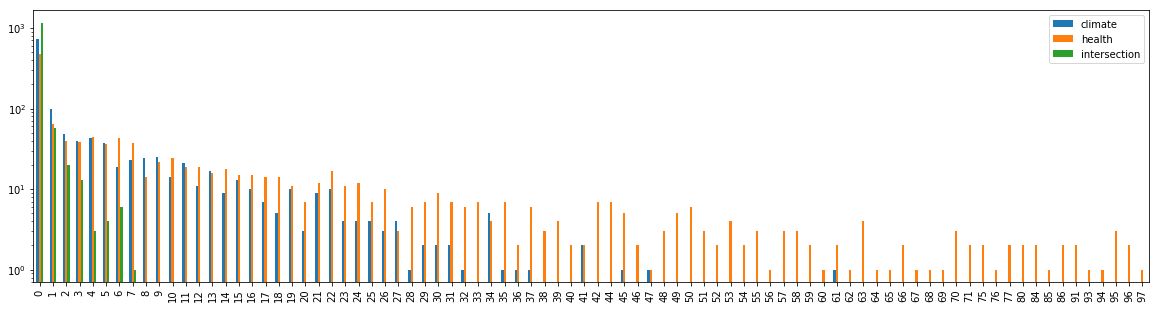

In [272]:
df_histogram_number_of_mentions = pd.DataFrame(data=histogram_number_of_mentions)
df_histogram_number_of_mentions.filter(items=list(range(0,100)),axis=0).plot.bar(logy=True, figsize=(20,5))

### References per year: total, average, proportion, per WHO region

In [273]:
df_per_year = pd.DataFrame(data=per_year)
df_per_year

climate  health  intersection
2011      785    1454             8
2012      634    2466            17
2013      621    2899            28
2014      707    2580            35
2015      832    3565            41
2016      656    3759            47
2017      834    3999            35

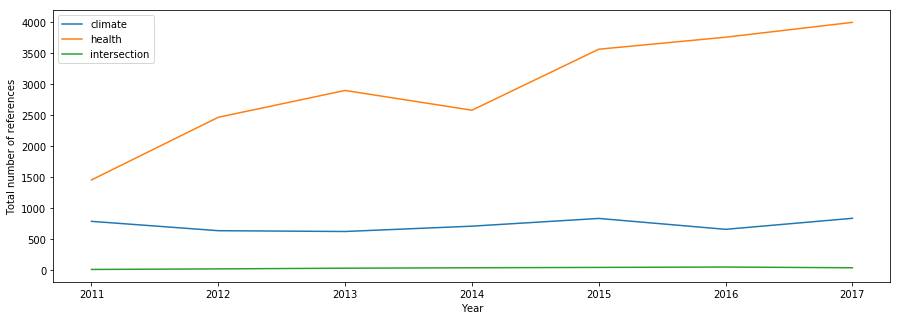

In [274]:
ax = df_per_year.filter(items=['2011','2012','2013','2014','2015','2016','2017'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels([0, '2011','2012','2013','2014','2015','2016','2017'])
ax.set_xlabel("Year")
ax.set_ylabel("Total number of references")
ax


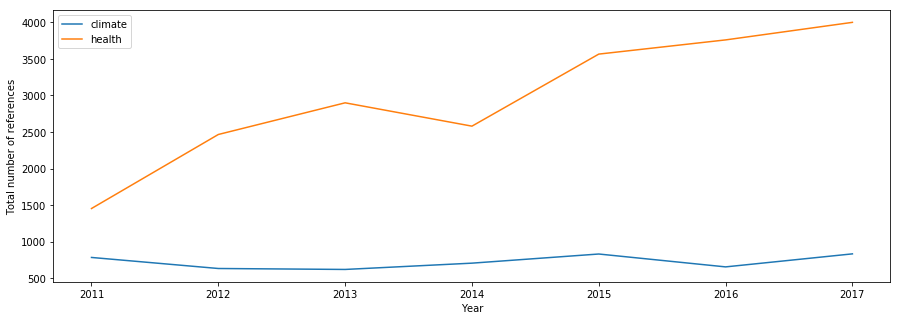

In [275]:
ax = df_per_year.filter(items=['2011','2012','2013','2014','2015','2016','2017'],axis=0).filter(items=["climate","health"],axis=1).plot.line(figsize=(15,5))
ax.set_xticklabels([0, '2011','2012','2013','2014','2015','2016','2017'])
ax.set_xlabel("Year")
ax.set_ylabel("Total number of references")
ax

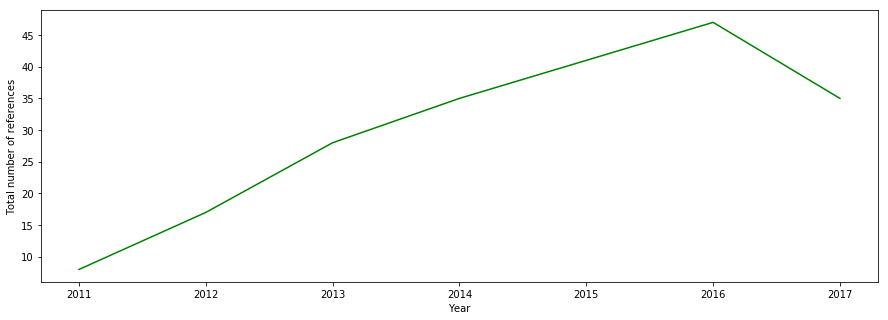

In [276]:
ax = df_per_year.filter(items=['2011','2012','2013','2014','2015','2016','2017'],axis=0).filter(items=["intersection"],axis=1).plot.line(figsize=(15,5), color="green", legend=False)
ax.set_xticklabels([0, '2011','2012','2013','2014','2015','2016','2017'])
ax.set_xlabel("Year")
ax.set_ylabel("Total number of references")
ax

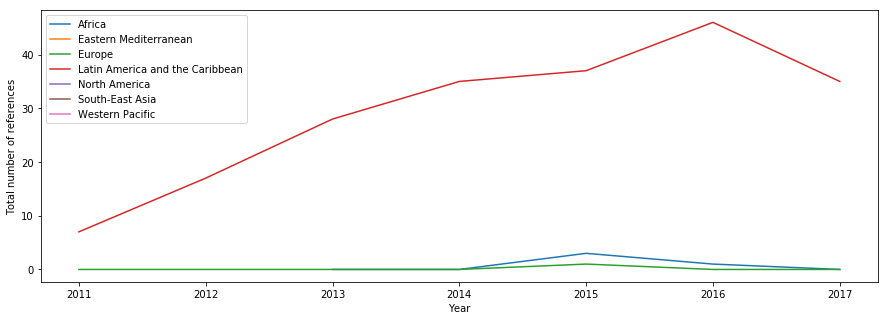

In [277]:
df_per_region_year_intersection = pd.DataFrame(data=per_region_year_intersection)
ax = df_per_region_year_intersection.filter(items=['2011','2012','2013','2014','2015','2016','2017'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels([0, '2011','2012','2013','2014','2015','2016','2017'])
ax.set_xlabel("Year")
ax.set_ylabel("Total number of references")
ax

In [278]:
df_average_per_year = pd.DataFrame(data=average_per_year)
df_average_per_year

climate     health  intersection
2011  6.652542  12.322034      0.067797
2012  4.283784  16.662162      0.114865
2013  3.763636  17.569697      0.169697
2014  3.842391  14.021739      0.190217
2015  4.058537  17.390244      0.200000
2016  3.200000  18.336585      0.229268
2017  3.418033  16.389344      0.143443

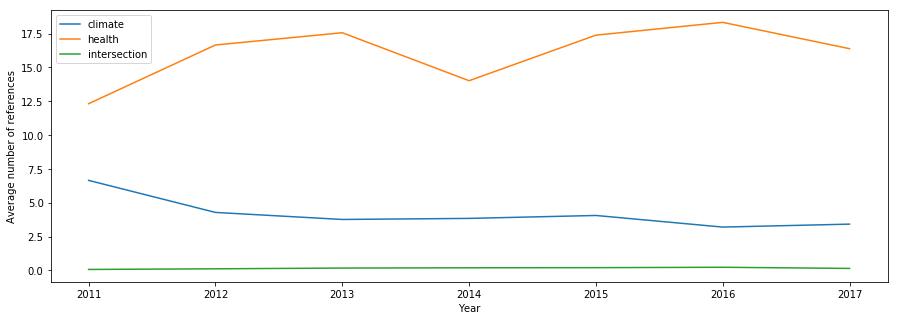

In [279]:
ax = df_average_per_year.filter(items=['2011','2012','2013','2014','2015','2016','2017'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels([0, '2011','2012','2013','2014','2015','2016','2017'])
ax.set_xlabel("Year")
ax.set_ylabel("Average number of references")
ax

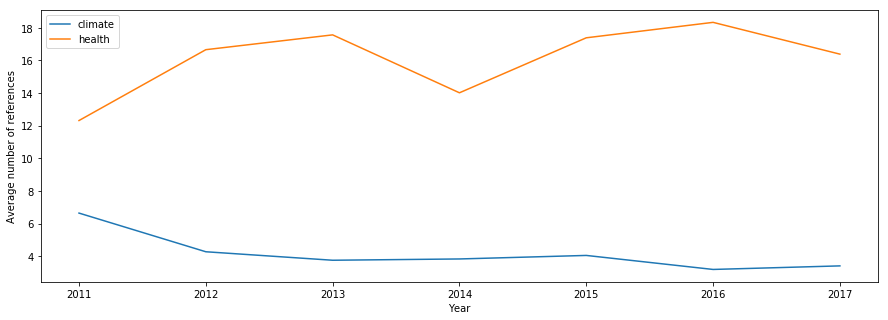

In [280]:
ax = df_average_per_year.filter(items=['2011','2012','2013','2014','2015','2016','2017'],axis=0).filter(items=["climate","health"],axis=1).plot.line(figsize=(15,5))
ax.set_xticklabels([0, '2011','2012','2013','2014','2015','2016','2017'])
ax.set_xlabel("Year")
ax.set_ylabel("Average number of references")
ax

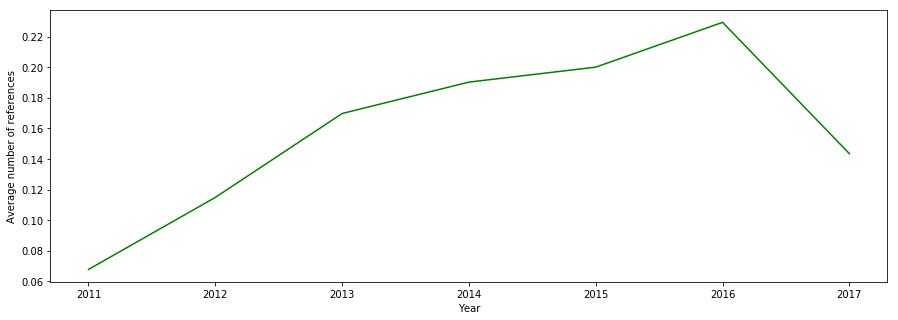

In [281]:
ax = df_average_per_year.filter(items=['2011','2012','2013','2014','2015','2016','2017'],axis=0).filter(items=["intersection"],axis=1).plot.line(figsize=(15,5), color="green", legend=False)
ax.set_xticklabels([0, '2011','2012','2013','2014','2015','2016','2017'])
ax.set_xlabel("Year")
ax.set_ylabel("Average number of references")
ax

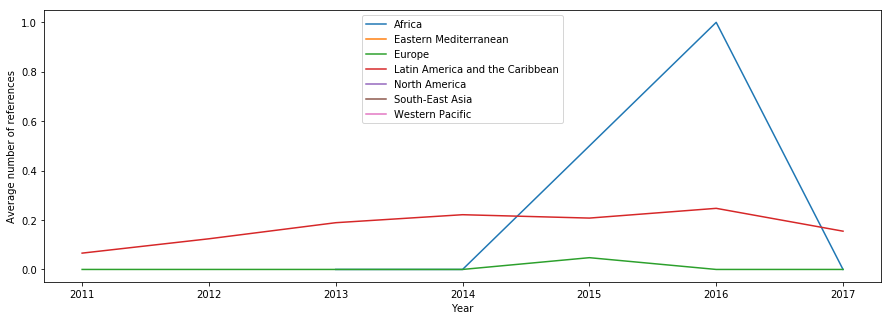

In [282]:
df_average_per_region_year_intersection = pd.DataFrame(data=average_per_region_year_intersection)
ax = df_average_per_region_year_intersection.filter(items=['2011','2012','2013','2014','2015','2016','2017'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels([0, '2011','2012','2013','2014','2015','2016','2017'])
ax.set_xlabel("Year")
ax.set_ylabel("Average number of references")
ax

In [283]:
df_proportion_per_year = pd.DataFrame(data=proportion_per_year)
df_proportion_per_year

climate     health  intersection
2011  33.898305  51.694915      5.084746
2012  35.135135  64.189189      6.081081
2013  41.212121  60.000000      9.090909
2014  44.565217  64.130435      7.608696
2015  43.414634  66.341463      8.292683
2016  42.439024  62.439024      9.756098
2017  49.180328  65.573770      9.426230

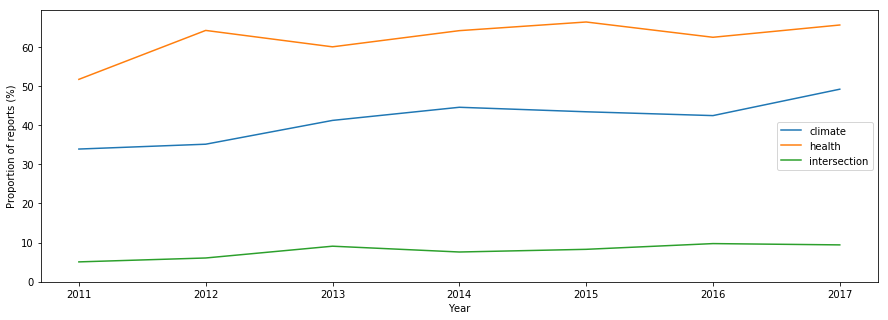

In [284]:
ax = df_proportion_per_year.filter(items=['2011','2012','2013','2014','2015','2016','2017'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels([0, '2011','2012','2013','2014','2015','2016','2017'])
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of reports (%)")
ax.set_ylim(ymin=0)
ax

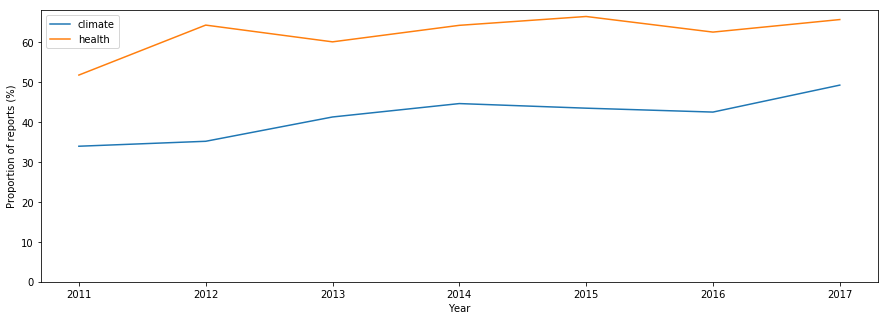

In [285]:
ax = df_proportion_per_year.filter(items=['2011','2012','2013','2014','2015','2016','2017'],axis=0).filter(items=["climate","health"],axis=1).plot.line(figsize=(15,5))
ax.set_xticklabels([0, '2011','2012','2013','2014','2015','2016','2017'])
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of reports (%)")
ax.set_ylim(ymin=0)
ax

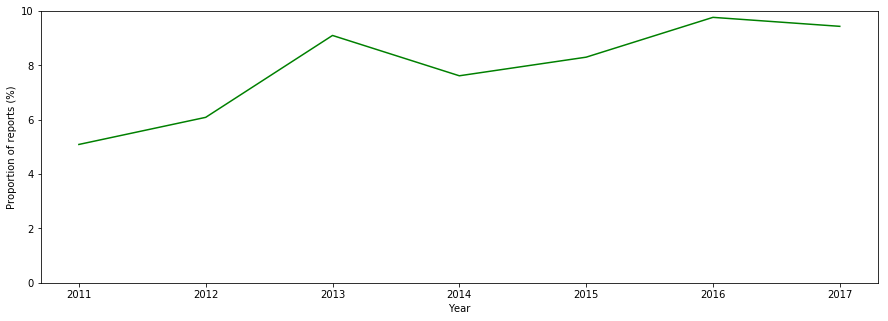

In [286]:
ax = df_proportion_per_year.filter(items=['2011','2012','2013','2014','2015','2016','2017'],axis=0).filter(items=["intersection"],axis=1).plot.line(figsize=(15,5), color="green", legend=False)
ax.set_xticklabels([0, '2011','2012','2013','2014','2015','2016','2017'])
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of reports (%)")
ax.set_ylim(ymin=0)
ax

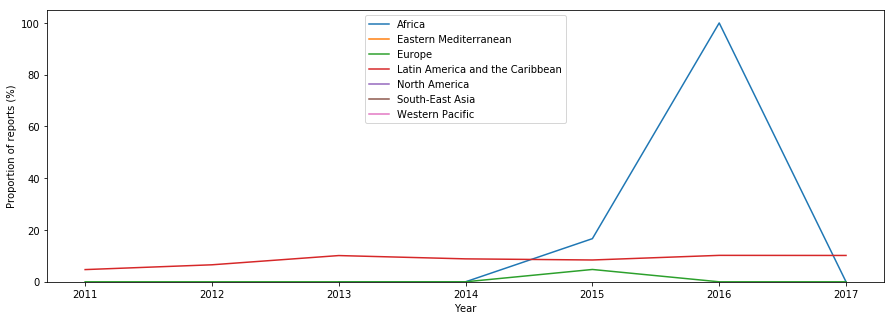

In [287]:
df_proportion_per_region_year_intersection = pd.DataFrame(data=proportion_per_region_year_intersection)
ax = df_proportion_per_region_year_intersection.filter(items=['2011','2012','2013','2014','2015','2016','2017'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels([0, '2011','2012','2013','2014','2015','2016','2017'])
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of reports (%)")
ax.set_ylim(ymin=0)
ax

### References per sector: total, average, proportion

In [288]:
df_per_sector = pd.DataFrame(data=per_sector)
df_per_sector

climate  health  intersection
Aerospace & Defense                  85     279             6
Alternative Energy                    6      15             0
Automobiles & Parts                   0      81             0
Banks                                68     178             2
Beverages                             6      96             0
Chemicals                           176     433             0
Construction & Materials            172     984            10
Diversified                          21      30             0
Electricity                        1039    2925            24
Electronic & Electrical Equ...       14     123             1
Financial Services                  549     779             8
Fixed Line Telecommunications       135     414             7
Food Producers                      133     848             4
Forestry & Paper                    254     500             4
Gas, Water & Multiutilities         155     345             2
General Industrials                 128     314             1
General Retailers                    58     175             1
Health Care Equipment & Ser...      334    7258            73
Household Goods & Home Cons...       22       7             0
Industrial Engineering                9     104             0
Industrial Metals & Mining          200     697            26
Industrial Transportation           109     207             9
Life Insurance                       34     186             2
Media                                47      62             0
Mining                               37     117             0
Mobile Telecommunications           162     165             6
Nonlife Insurance                     0       5             0
Not Applicable                       36     158             2
Oil & Gas Producers                  36     193             0
Oil Equipment, Services & D...       25      58             0
Personal Goods                      297     130             3
Pharmaceuticals & Biotechno...        3      20             0
Real Estate Investment & Se...        5      61             0
Software & Computer Services         23     503             0
Support Services                    654    2143            20
Technology Hardware & Equip...        1       2             0
Tobacco                               6      27             0
Travel & Leisure                     30     100             0

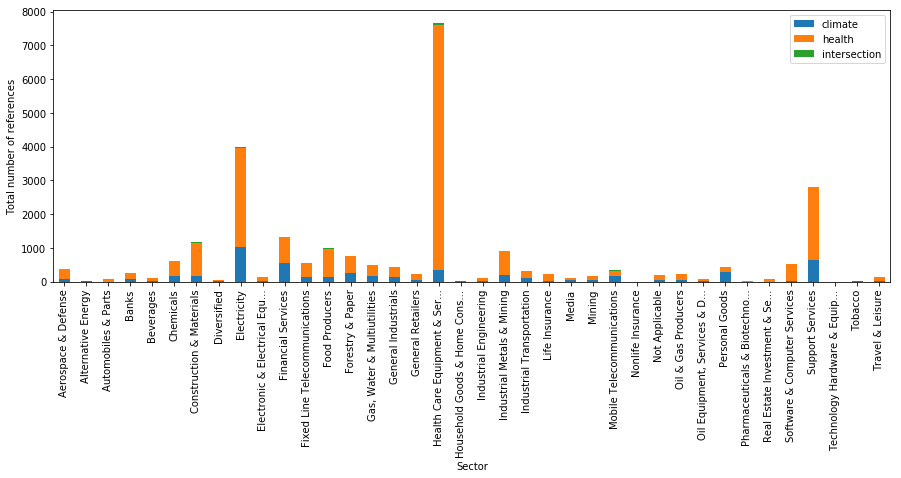

In [289]:
ax = df_per_sector.loc[(df_per_sector['climate'] > 0) | (df_per_sector['health'] > 0)].plot.bar(stacked=True,figsize=(15,5))
ax.set_xlabel("Sector")
ax.set_ylabel("Total number of references")
ax

In [290]:
df_average_per_sector = pd.DataFrame(data=average_per_sector)
df_average_per_sector

climate     health  intersection
Aerospace & Defense              6.538462  21.461538      0.461538
Alternative Energy               1.500000   3.750000      0.000000
Automobiles & Parts              0.000000   7.363636      0.000000
Banks                            7.555556  19.777778      0.222222
Beverages                        0.600000   9.600000      0.000000
Chemicals                        5.866667  14.433333      0.000000
Construction & Materials         2.356164  13.479452      0.136986
Diversified                      3.500000   5.000000      0.000000
Electricity                      7.696296  21.666667      0.177778
Electronic & Electrical Equ...   2.000000  17.571429      0.142857
Financial Services               6.614458   9.385542      0.096386
Fixed Line Telecommunications    5.869565  18.000000      0.304348
Food Producers                   2.829787  18.042553      0.085106
Forestry & Paper                 8.466667  16.666667      0.133333
Gas, Water & Multiutilities      4.078947   9.078947      0.052632
General Industrials              2.000000   4.906250      0.015625
General Retailers                2.000000   6.034483      0.034483
Health Care Equipment & Ser...   2.211921  48.066225      0.483444
Household Goods & Home Cons...   5.500000   1.750000      0.000000
Industrial Engineering           0.409091   4.727273      0.000000
Industrial Metals & Mining       7.692308  26.807692      1.000000
Industrial Transportation        6.055556  11.500000      0.500000
Life Insurance                   4.250000  23.250000      0.250000
Media                            1.958333   2.583333      0.000000
Mining                           1.321429   4.178571      0.000000
Mobile Telecommunications       18.000000  18.333333      0.666667
Nonlife Insurance                0.000000   5.000000      0.000000
Not Applicable                   1.714286   7.523810      0.095238
Oil & Gas Producers              7.200000  38.600000      0.000000
Oil Equipment, Services & D...   4.166667   9.666667      0.000000
Personal Goods                  21.214286   9.285714      0.214286
Pharmaceuticals & Biotechno...   0.272727   1.818182      0.000000
Real Estate Investment & Se...   0.294118   3.588235      0.000000
Software & Computer Services     0.328571   7.185714      0.000000
Support Services                 3.715909  12.176136      0.113636
Technology Hardware & Equip...   0.166667   0.333333      0.000000
Tobacco                          1.200000   5.400000      0.000000
Travel & Leisure                 0.857143   2.857143      0.000000

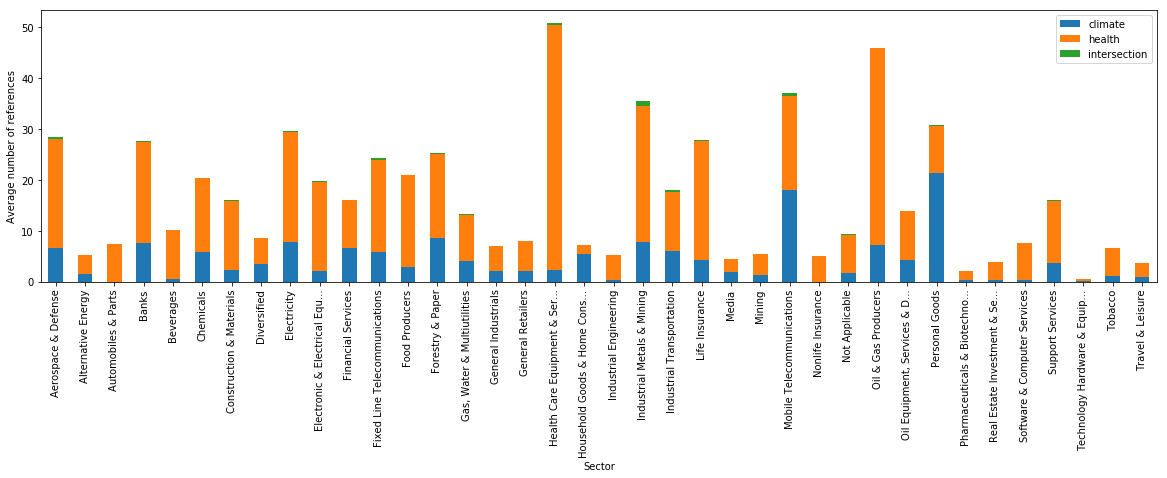

In [291]:
ax = df_average_per_sector.loc[(df_average_per_sector['climate'] > 0) | (df_average_per_sector['health'] > 0)].plot.bar(stacked=True,figsize=(20,5))
ax.set_xlabel("Sector")
ax.set_ylabel("Average number of references")
ax

In [292]:
df_proportion_per_sector = pd.DataFrame(data=proportion_per_sector)
df_proportion_per_sector

climate      health  intersection
Aerospace & Defense             53.846154   76.923077      7.692308
Alternative Energy              50.000000   75.000000      0.000000
Automobiles & Parts              0.000000   81.818182      0.000000
Banks                           77.777778   77.777778     22.222222
Beverages                       20.000000   60.000000      0.000000
Chemicals                       33.333333   73.333333      0.000000
Construction & Materials        34.246575   67.123288      5.479452
Diversified                     16.666667   33.333333      0.000000
Electricity                     70.370370   74.814815     11.851852
Electronic & Electrical Equ...  42.857143   85.714286     14.285714
Financial Services              49.397590   63.855422      8.433735
Fixed Line Telecommunications   47.826087   73.913043     21.739130
Food Producers                  51.063830   72.340426      4.255319
Forestry & Paper                56.666667   63.333333     13.333333
Gas, Water & Multiutilities     39.473684   44.736842      2.631579
General Industrials             21.875000   45.312500      1.562500
General Retailers               37.931034   55.172414      3.448276
Health Care Equipment & Ser...  42.384106   64.238411     15.894040
Household Goods & Home Cons...  75.000000   50.000000      0.000000
Industrial Engineering          31.818182   50.000000      0.000000
Industrial Metals & Mining      76.923077   84.615385     26.923077
Industrial Transportation       72.222222   83.333333     27.777778
Life Insurance                  50.000000   87.500000     25.000000
Media                           41.666667   54.166667      0.000000
Mining                          14.285714   50.000000      0.000000
Mobile Telecommunications       88.888889   88.888889     33.333333
Nonlife Insurance                0.000000  100.000000      0.000000
Not Applicable                  28.571429   57.142857      4.761905
Oil & Gas Producers             60.000000   60.000000      0.000000
Oil Equipment, Services & D...  33.333333   50.000000      0.000000
Personal Goods                  85.714286   85.714286     21.428571
Pharmaceuticals & Biotechno...  18.181818   27.272727      0.000000
Real Estate Investment & Se...  17.647059   17.647059      0.000000
Software & Computer Services    17.142857   55.714286      0.000000
Support Services                38.636364   60.795455      7.954545
Technology Hardware & Equip...  16.666667   16.666667      0.000000
Tobacco                         80.000000   80.000000      0.000000
Travel & Leisure                20.000000   57.142857      0.000000

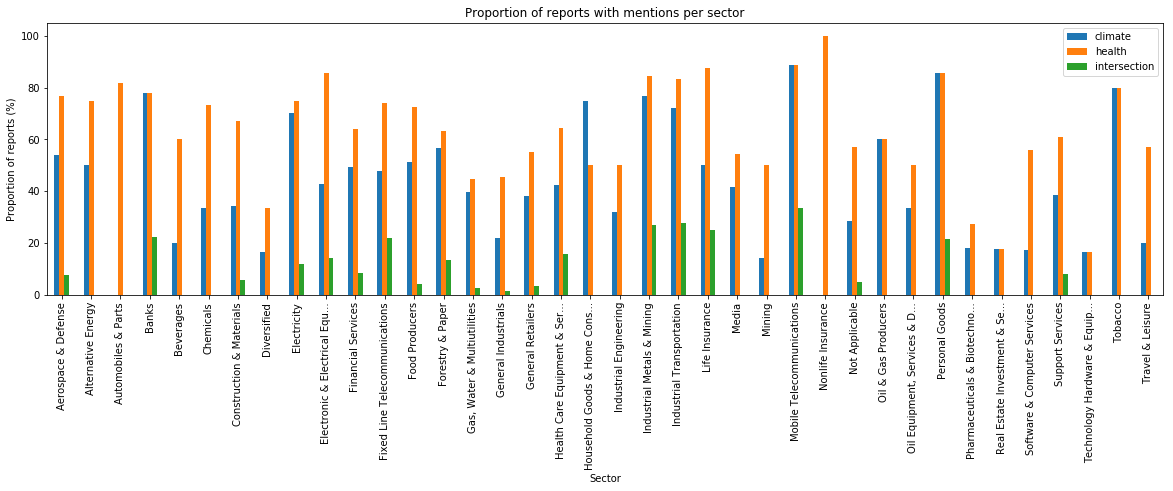

In [293]:
ax = df_proportion_per_sector.loc[(df_proportion_per_sector['climate'] > 0) | (df_proportion_per_sector['health'] > 0)].plot.bar(stacked=False,figsize=(20,5), title="Proportion of reports with mentions per sector")
ax.set_xlabel("Sector")
ax.set_ylabel("Proportion of reports (%)")
ax

### References per country: total

In [294]:
df_per_country = pd.DataFrame(data=per_country)
df_per_country.loc[(df_per_country['climate'] > 0) | (df_per_country['health'] > 0)]


climate  health  intersection
Angola                21     291             4
Argentina              1       0             0
Australia             16       9             1
Brazil              4823   19424           205
Cape Verde             3      90             0
Mozambique             0      67             0
Portugal             194     794             1
Sao Tome And...        0       7             0
Spain                 11      40             0

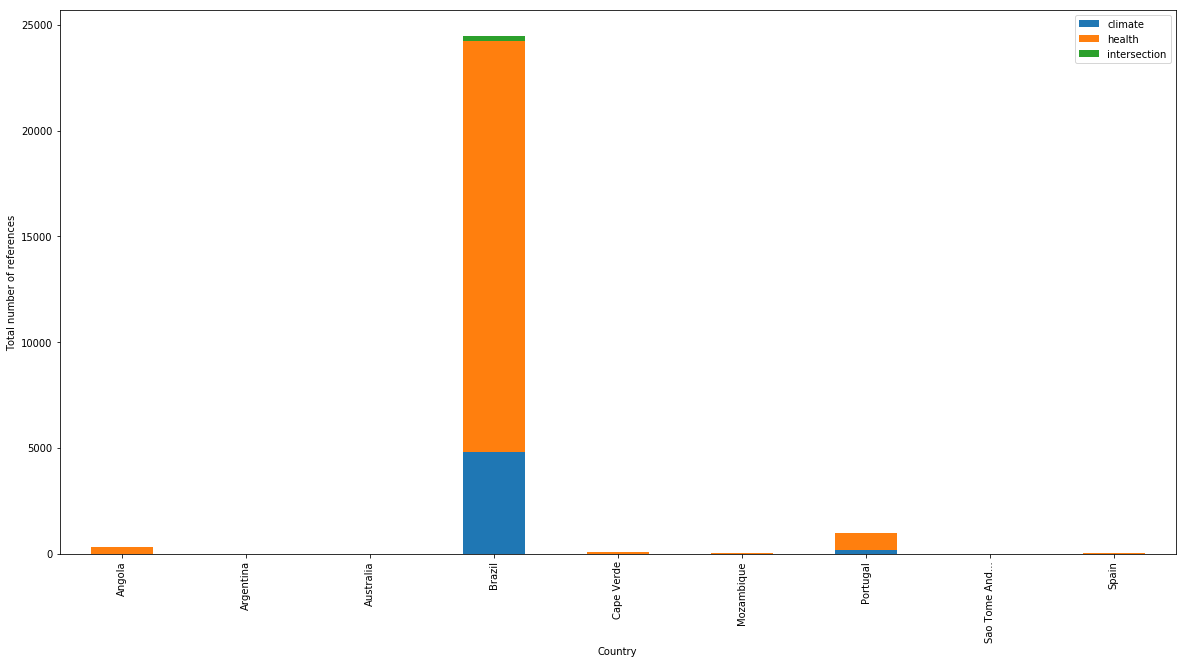

In [295]:
ax = df_per_country.loc[(df_per_country['climate'] > 0) | (df_per_country['health'] > 0)].plot.bar(stacked=True,figsize=(20,10))
ax.set_xlabel("Country")
ax.set_ylabel("Total number of references")
ax

### References per WHO region: total

In [296]:
df_per_region = pd.DataFrame(data=per_region)
df_per_region

climate  health  intersection
Africa                                21     365             4
Europe                               205     834             1
Latin America and the Caribbean     4824   19424           205
Western Pacific                       16       9             1

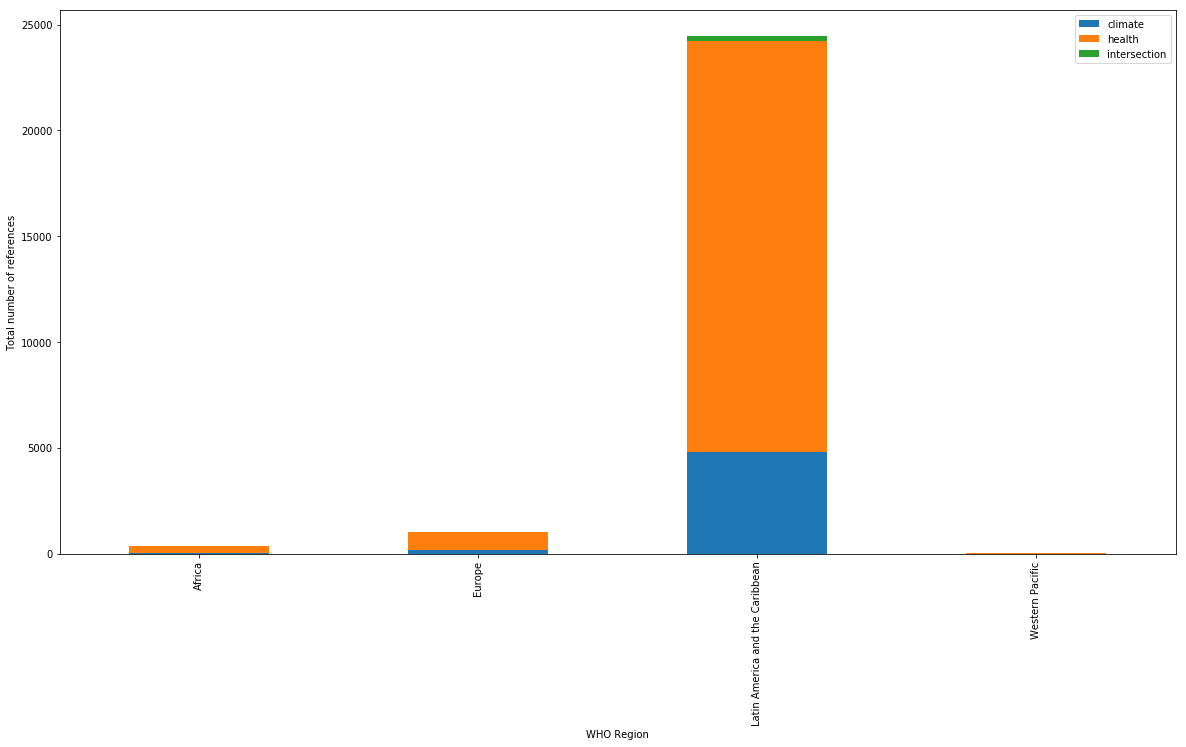

In [297]:
ax = df_per_region.plot.bar(stacked=True,figsize=(20,10))
ax.set_xlabel("WHO Region")
ax.set_ylabel("Total number of references")
ax

### References per country in 2017: total, average, proportion

Download shapefiles ne_110m_admin_0_countries.* from [here](https://github.com/nvkelso/natural-earth-vector/tree/master/110m_cultural)

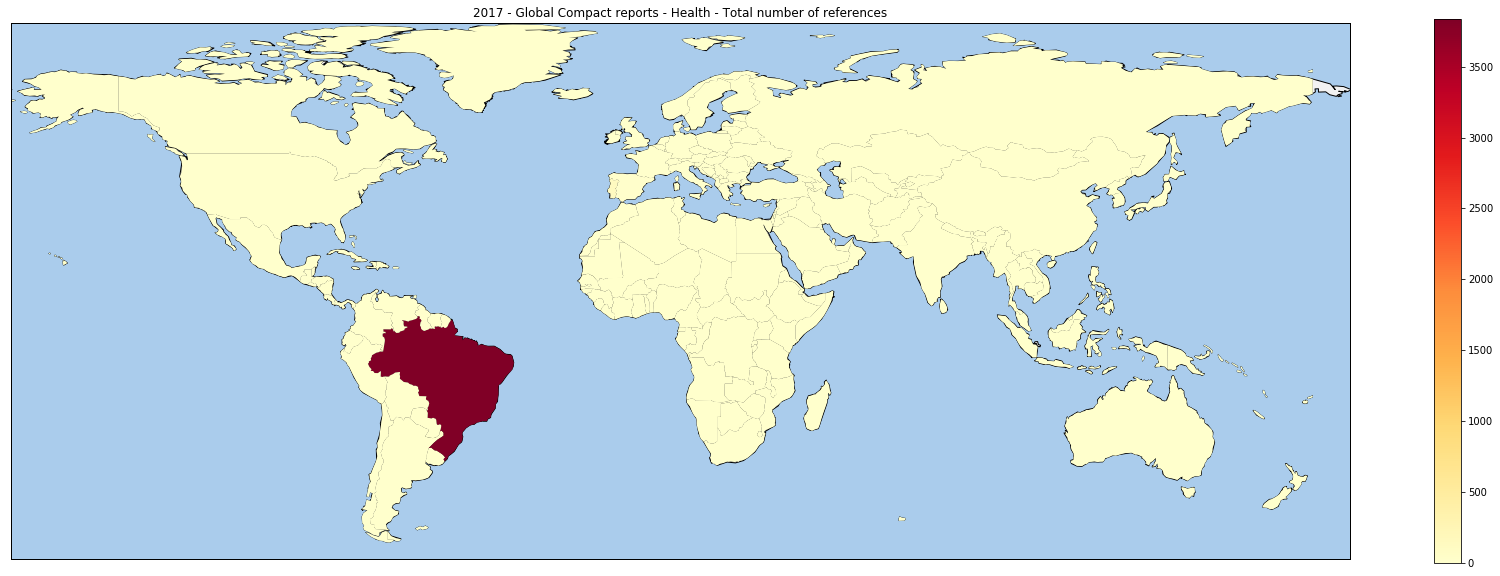

In [298]:
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

def create_map(per_country_counts, title, resolution='c'):

    mapped_country_names = {'Bosnia-Herze...' : 'Bosnia and Herz.', "Cote d'Ivoire" : "Côte d'Ivoire", 
                            'Congo, Democ...' : 'Dem. Rep. Congo', 'Dominican Re...' : 'Dominican Rep.', 
                            'Iran, Islami...' : 'Iran', 'Macedonia, T...' : 'Macedonia', 
                            'Moldova, Rep...' : 'Moldova', 'Palestine, S...' : 'Palestine', 
                            'Russian Fede...' : 'Russia', 'South Sudan' : 'S. Sudan', 
                            'Korea, Repub...' : 'South Korea' , 'Syrian Arab ...' : 'Syria', 
                            'Tanzania, Un...' : 'Tanzania', 'Trinidad And...' : 'Trinidad and Tobago', 
                            'United Arab ...' : 'United Arab Emirates', 'United State...' : 'United States of America',
                            'Viet Nam' : 'Vietnam'}

    per_normalised_country_counts = []
    for country, count in per_country_counts.items():
        if country in mapped_country_names:
            per_normalised_country_counts.append((mapped_country_names[country], count))
        else:
            per_normalised_country_counts.append((country, count))
    df_per_normalised_country_counts = pd.DataFrame(per_normalised_country_counts, columns=["country", "count"])

    fig, ax = plt.subplots(figsize=(30,20))
    plt.title(title)

    m = Basemap(resolution=resolution, # c, l, i, h, f or None
                projection='cyl',
                lat_0=0, lon_0=0,
                llcrnrlon=-170, llcrnrlat=-60, urcrnrlon=190, urcrnrlat=84)

    m.drawmapboundary(fill_color='#aaccec')
    m.fillcontinents(color='#f2f2f2',lake_color='#aaccec')
    m.drawcoastlines()
    m.readshapefile("ne_110m_admin_0_countries", "countries")
    shapename_regex = re.compile(r'(?<=^)[\w \.\']+')

    df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.countries],
        'country': [shapename_regex.search(area['NAME'])[0] for area in m.countries_info]
    })
    df_poly = df_poly.merge(df_per_normalised_country_counts, on='country', how='left', validate="many_to_one")

    cmap = plt.get_cmap('YlOrRd')   
    pc = PatchCollection(df_poly.shapes, zorder=2)
    norm = Normalize()
 
    pc.set_facecolor(cmap(norm(df_poly['count'].fillna(0).values)))
    ax.add_collection(pc)

    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    mapper.set_array(df_poly['count'])

    plt.colorbar(mapper, shrink=0.5)


create_map(per_country_focusyear["health"], "2017 - Global Compact reports - Health - Total number of references")

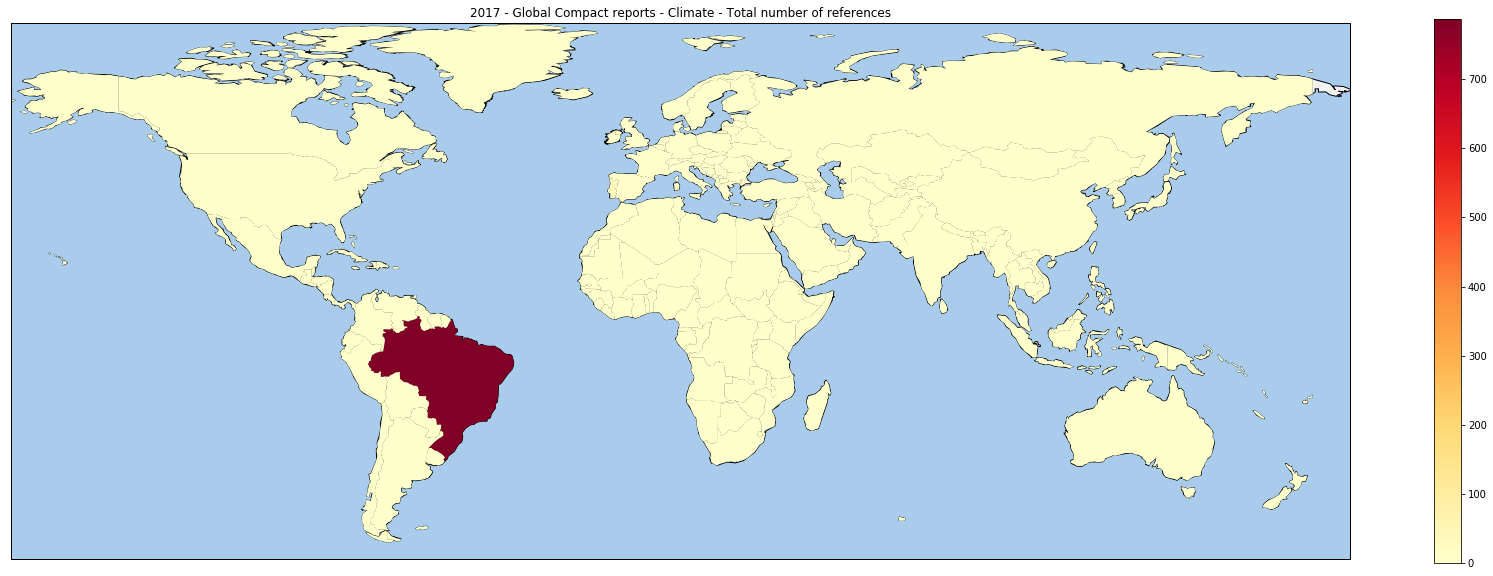

In [299]:
create_map(per_country_focusyear["climate"], "2017 - Global Compact reports - Climate - Total number of references")

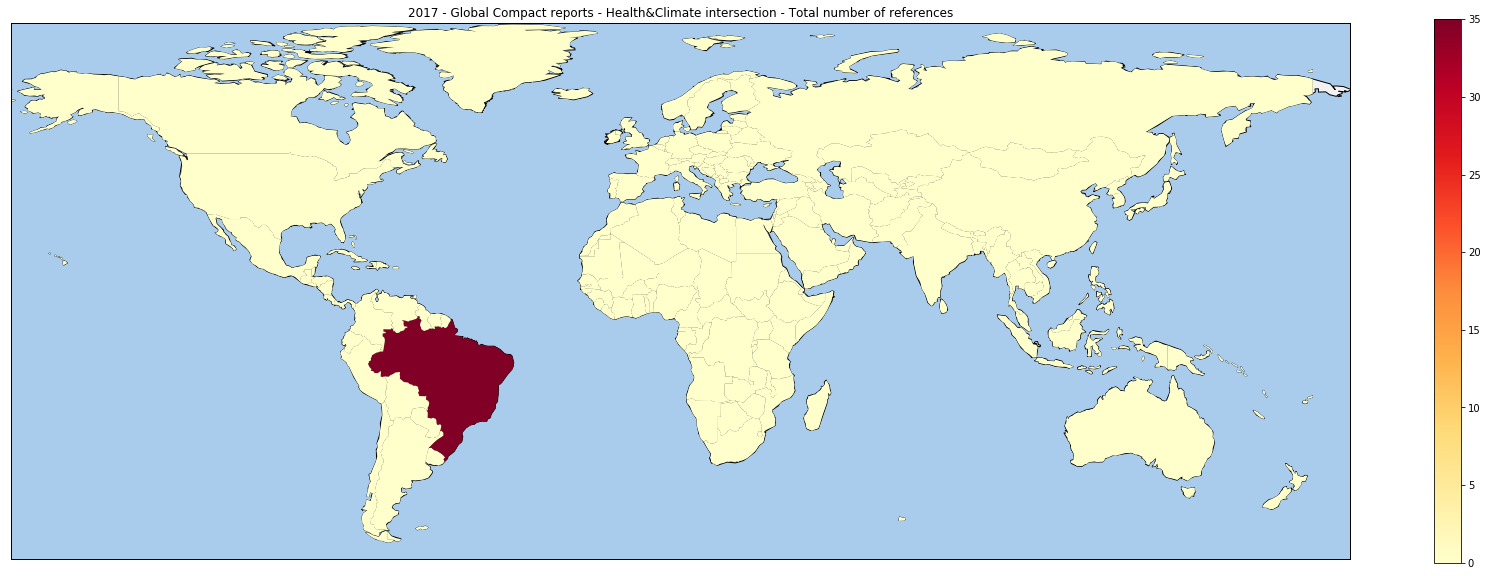

In [300]:
create_map(per_country_focusyear["intersection"], "2017 - Global Compact reports - Health&Climate intersection - Total number of references")


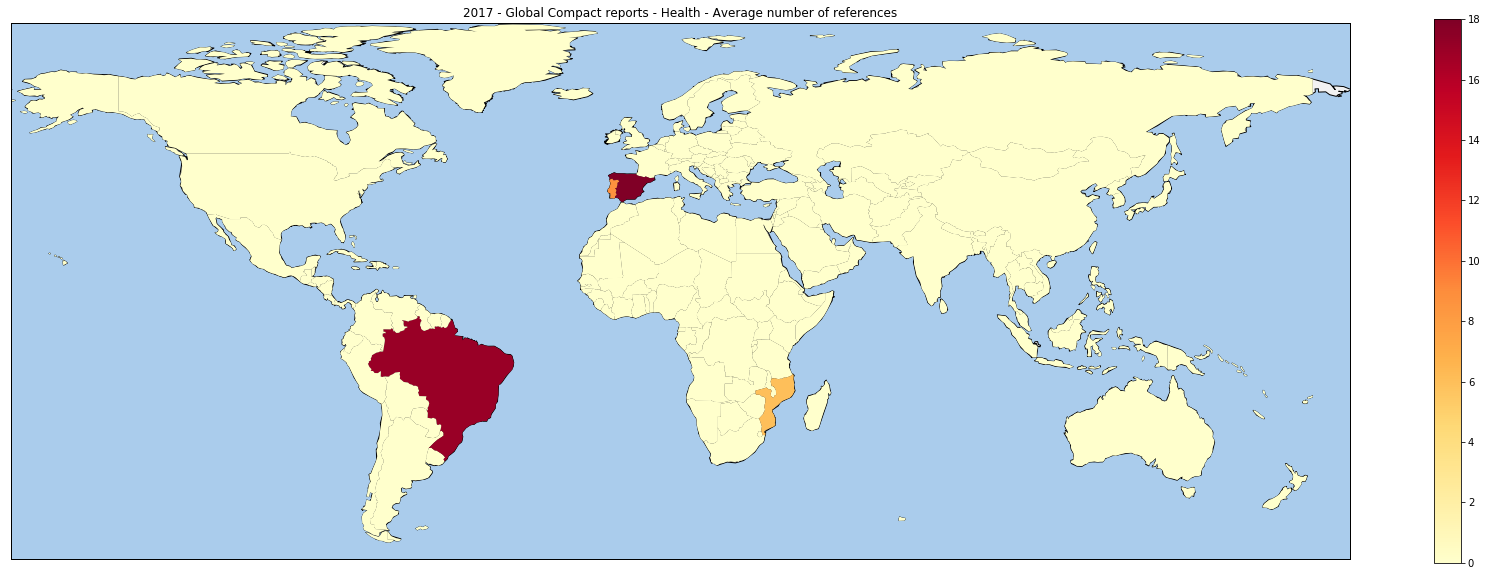

In [301]:
create_map(average_per_country_focusyear["health"], "2017 - Global Compact reports - Health - Average number of references")

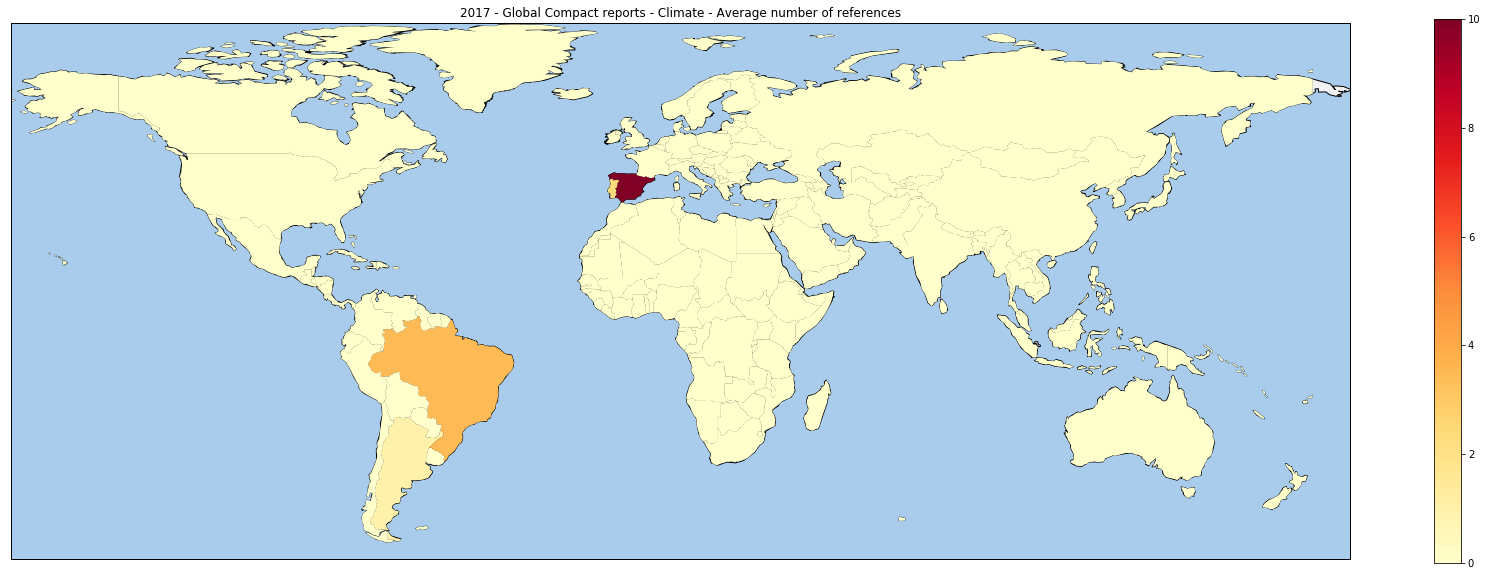

In [302]:
create_map(average_per_country_focusyear["climate"], "2017 - Global Compact reports - Climate - Average number of references")

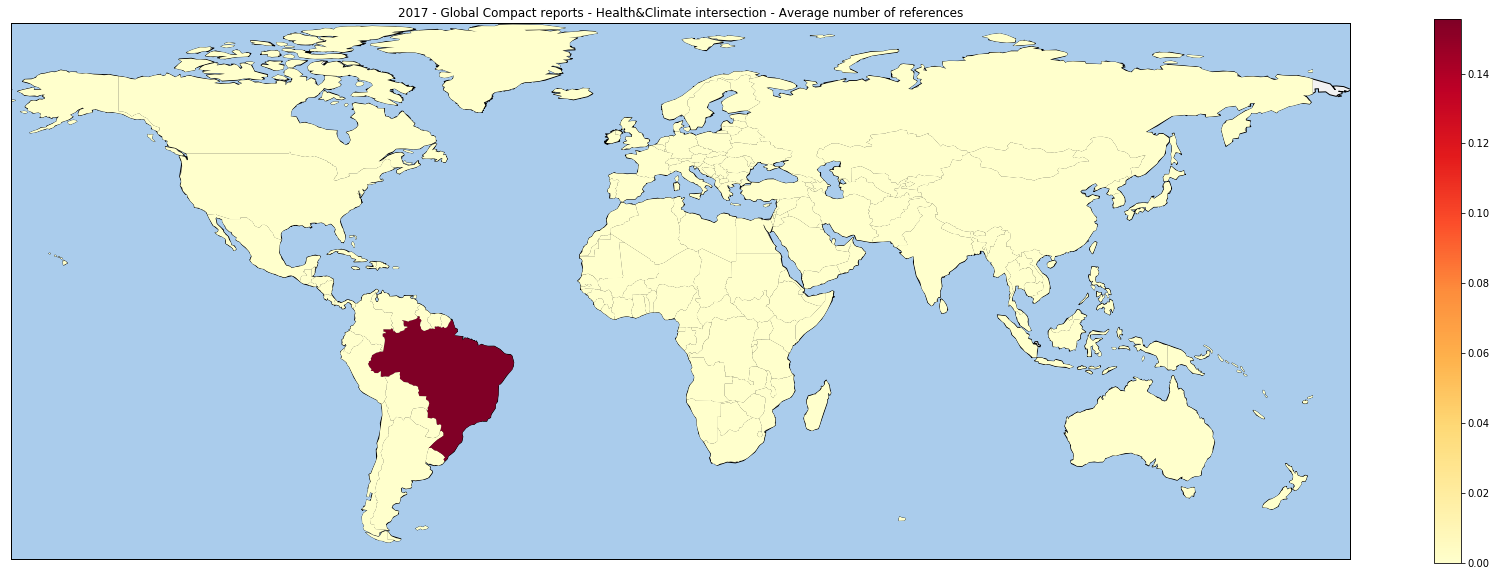

In [303]:
create_map(average_per_country_focusyear["intersection"], "2017 - Global Compact reports - Health&Climate intersection - Average number of references")

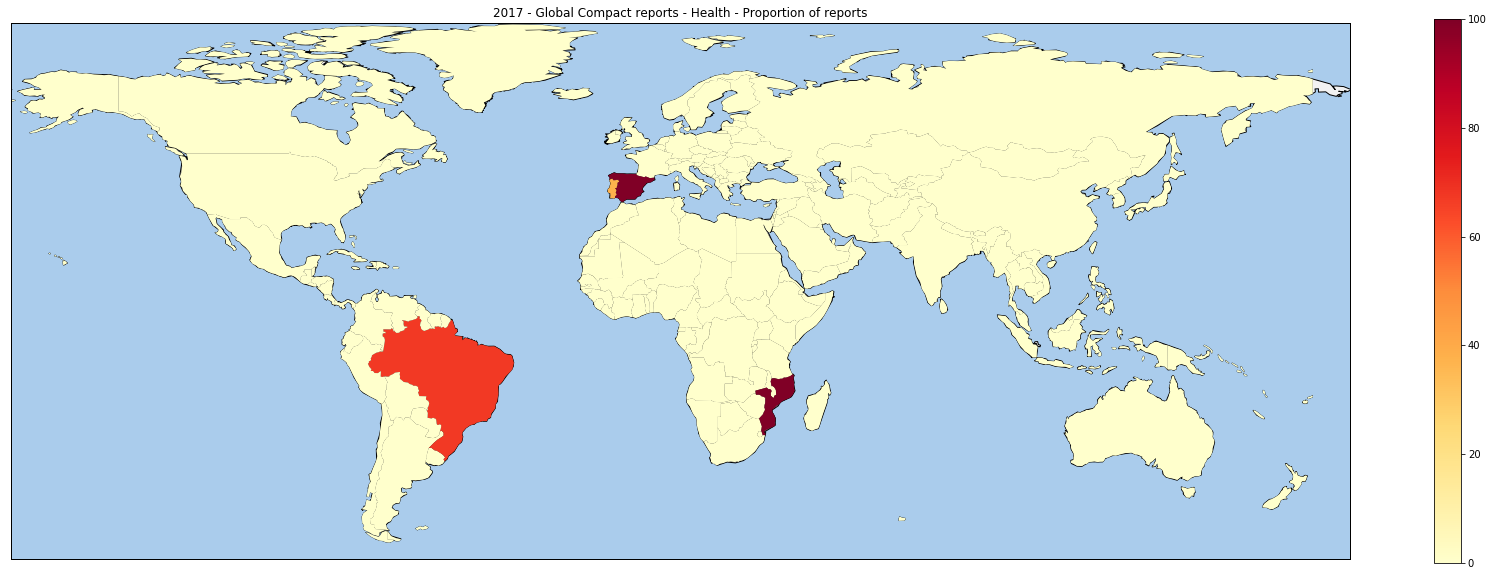

In [304]:
create_map(proportion_per_country_focusyear["health"], "2017 - Global Compact reports - Health - Proportion of reports")

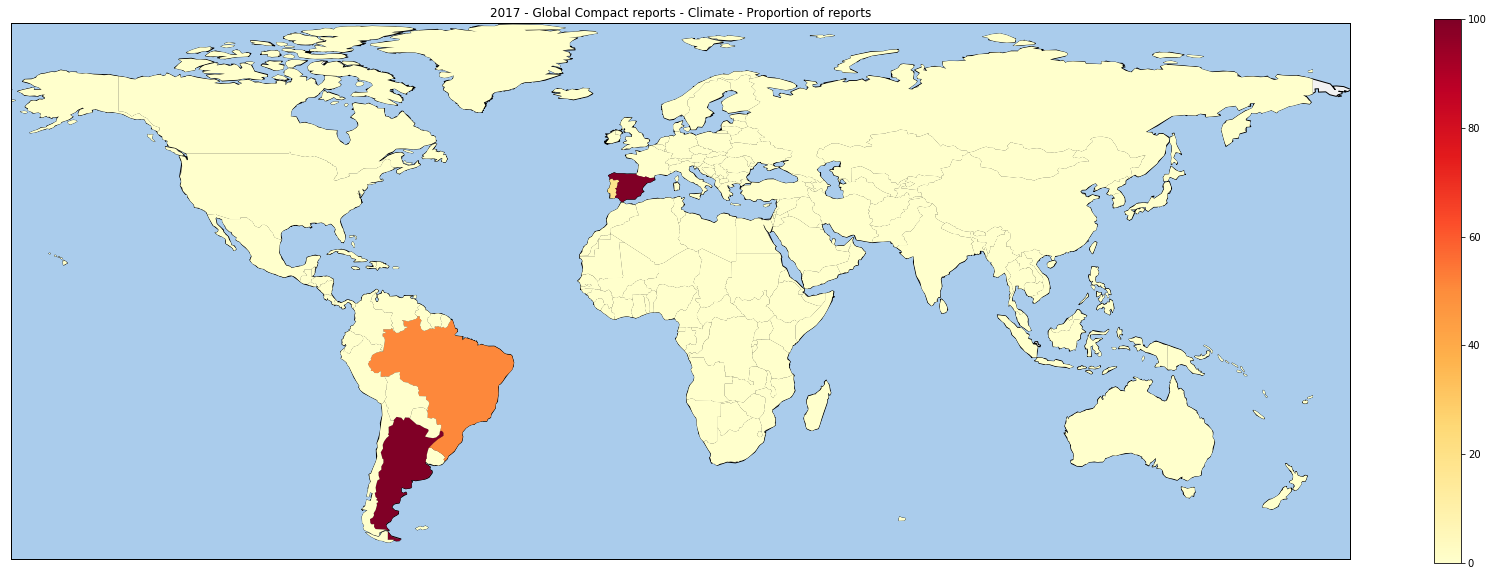

In [305]:
create_map(proportion_per_country_focusyear["climate"], "2017 - Global Compact reports - Climate - Proportion of reports")

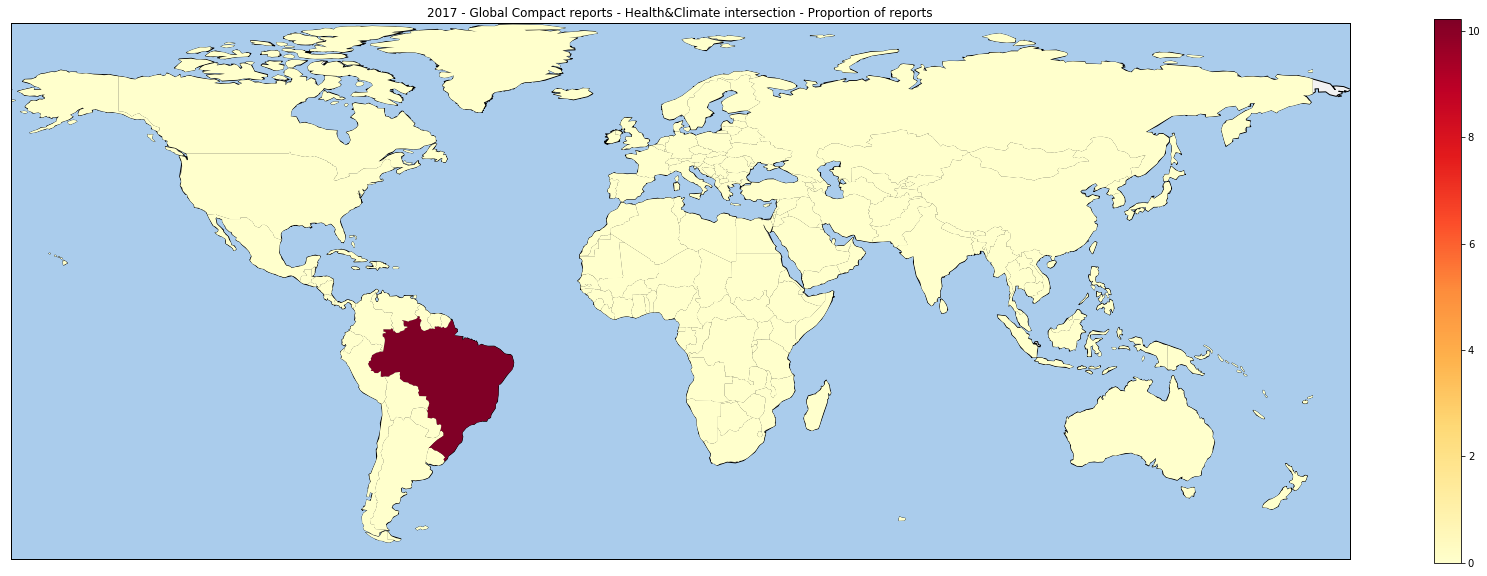

In [306]:
create_map(proportion_per_country_focusyear["intersection"], "2017 - Global Compact reports - Health&Climate intersection - Proportion of reports")

### Frenquency of keywords: health and climate

In [307]:
df_health_keywords = pd.DataFrame(sorted(global_count_health_keywords.items(), key=lambda k: k[1], reverse=True), columns=["Keyword", "Number of mentions"])
df_health_keywords

Keyword  Number of mentions
0            saúde               19298
1           doença                 571
2         nutrição                 332
3      mortalidade                 170
4    saúde_pública                 111
5          malária                  85
6         infecção                  63
7   poluição_do_ar                  39
8         epidemia                  15
9    epidemiologia                  11
10     desnutrição                  10
11       morbidade                   7
12         sarampo                   4
13       pneumonia                   3
14        pandemia                   3

In [308]:
df_climate_keywords = pd.DataFrame(sorted(global_count_climate_keywords.items(), key=lambda k: k[1], reverse=True), columns=["Keyword", "Number of mentions"])
df_climate_keywords

Keyword  Number of mentions
0                   estufa                2694
1      mudanças_climáticas                1451
2        energia_renovável                 278
3              temperatura                 252
4       aquecimento_global                 170
5            baixo_carbono                 133
6      emissões_de_carbono                  90
7  variabilidade_climática                   1

### Word clouds: health, climate, intersection

Up to 200 most frequent words that appear in the context of our health or climate keywords or both

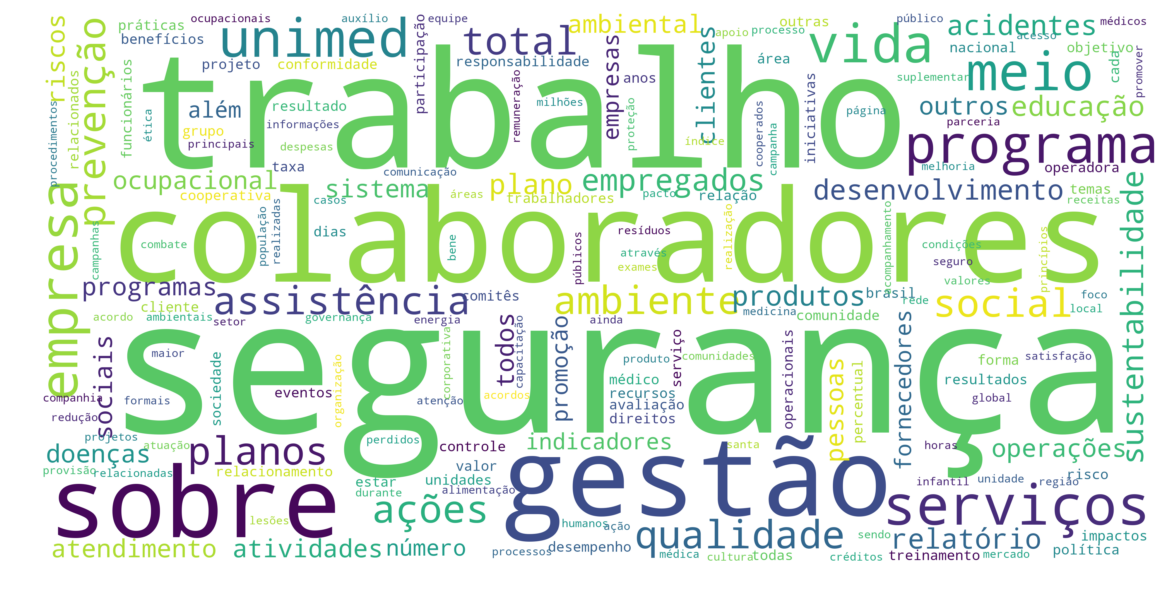

In [309]:
import collections
from wordcloud import WordCloud, STOPWORDS
from stop_words import get_stop_words

threshold = 200

language_specific_stopwords = get_stop_words(focus_language)

def create_wordcloud(contexts, stopwords=[]):
    most_frequent_words = {}
    stopwords.extend(STOPWORDS)
    stopwords.extend(language_specific_stopwords)

    context_unigrams = collections.Counter(contexts)
    for word, freq in sorted(context_unigrams.items(), key=lambda k: k[1], reverse=True)[0:threshold]:
        if word not in stopwords:
            most_frequent_words[word] = freq

    wordcloud = WordCloud(background_color="white", scale=10).generate_from_frequencies(most_frequent_words)

    fig = plt.figure(1, figsize=(20, 12))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()
    

create_wordcloud(global_health_contexts, health_dict)

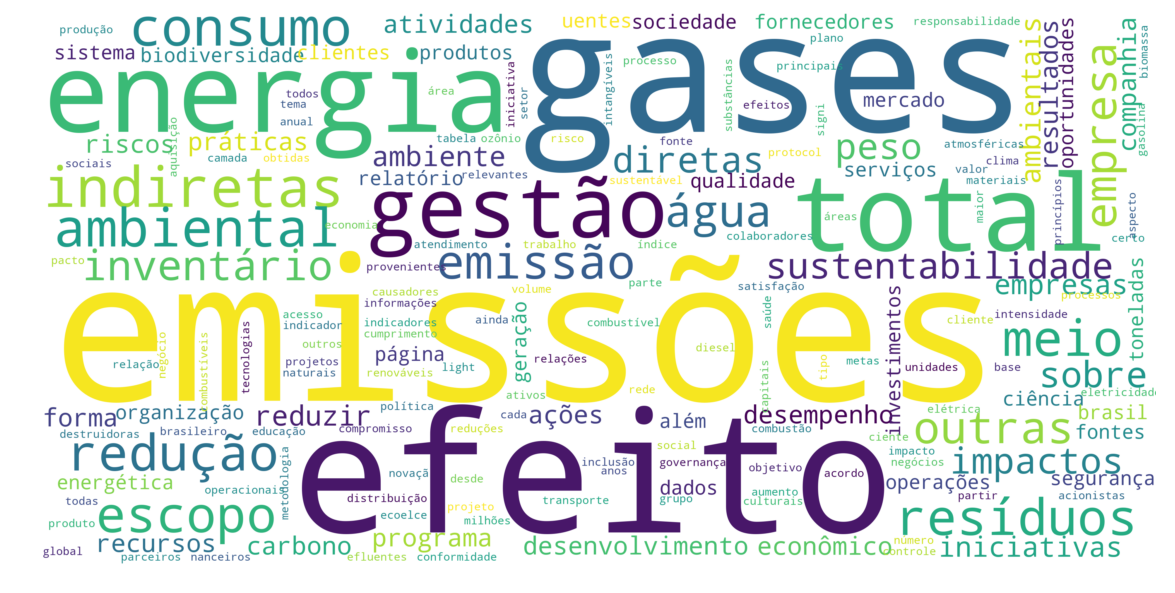

In [310]:
create_wordcloud(global_climate_contexts, climate_dict)

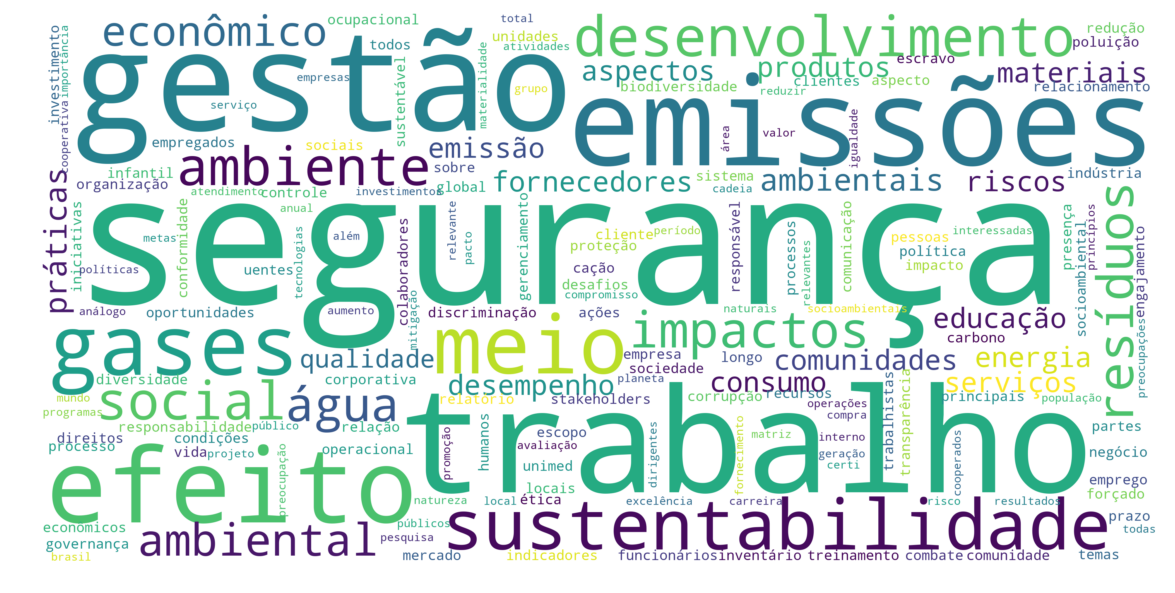

In [311]:
create_wordcloud(global_intersection_contexts, climate_dict + health_dict)

### Network graphs: intersection
Blue nodes are health keywords and green nodes are climate keywords. The closer the nodes are to each other, the more often the words co-occur. The graph only shows links between words that co-occurred 10 or more times in the whole corpus.

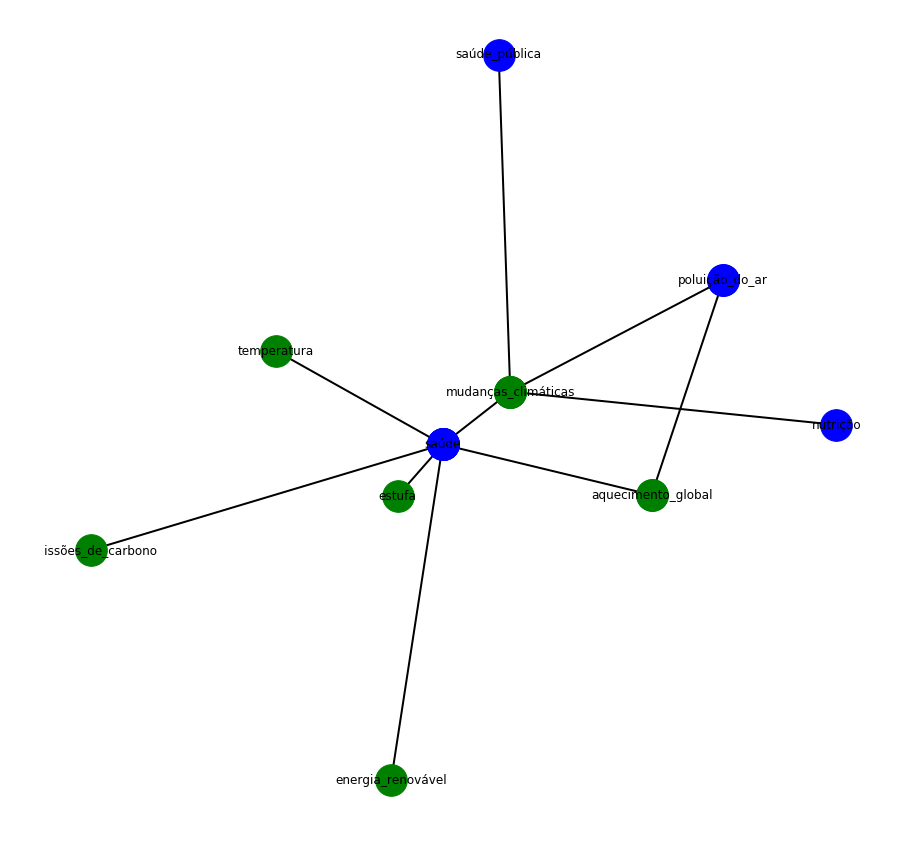

In [312]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


G = nx.Graph()

health_nodes = []
climate_nodes = []

for word1 in cooccurrence_matrix.keys():
    for word2 in cooccurrence_matrix[word1].keys():
        if cooccurrence_matrix[word1][word2] >= language_ref[focus_language]['min_coocurrence']:
            G.add_edge(word1, word2, weight=cooccurrence_matrix[word1][word2])
            health_nodes.append(word1)
            climate_nodes.append(word2)

plt.figure(figsize=(15,15))

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=health_nodes, node_size=1000, node_color='b')
nx.draw_networkx_nodes(G, pos, nodelist=climate_nodes, node_size=1000, node_color='g')
nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), width=2)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
#edge_labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_family='sans-serif')

plt.axis('off')
plt.show()